# Monitoring the impact of climate change on rainfall-related hazards in Svalbard with a global and a regional reanalysis dataset [Reanalysis]-[Intercomparison]-[Climate monitoring]

Production date: 05-11-2025 

Produced by: Fabio Mangini, Nansen Environmental and Remote Sensing Center (NERSC)   

## 🌍 Use case: Monitoring the impact of climate change on rainfall-related hazards in Svalbard

## ❓ Quality assessment question
* **How well do CARRA and ERA5 reproduce variations in temperature, precipitation, and frequency of rain-on-snow events across Svalbard?**
* **Can CARRA be used to assess whether the frequency of rain-on-snow events has changed across Svalbard over the last three decades?** 

Rain-on-snow (ROS) events occur when rain falls over pre-existing snowpacks and freezes. As it freezes, rain forms a layer of ice that can potentially threaten wildlife and human communities (e.g., Peeters et al., 2019). The relevance of ROS events is particularly pronounced over Svalbard due to the intense warming that has affected the region in the last decades (Hanssen-Bauer et al., 2019). To illustrate, the annual-mean temperature averaged over Svalbard increased by 0.87°C/decade between 1971 and 2017, while the global-averaged temperature raised by slightly more than one fifth over the same period (Wickström et al., 2020). This change, which is the local manifestation of a larger-scale phenomenon known as Arctic Amplification (Rantanen et al., 2022), might have modified the frequency of occurrence of ROS events in the region (Hansen et al., 2014) and might continue to do so in the future. Therefore, studying ROS events in Svalbard is important to develop efficient and timely solutions to the challenges caused by ROS events.  

The present assessment aims to analyse the ability of the Copernicus Arctic Regional Reanalysis (CARRA) dataset to study ROS events over Svalbard. CARRA is a regional reanalysis dataset that covers the European sector of the Arctic. It is of interest because it can potentially benefit Arctic climate studies by partly overcoming the limitations of the current observing and modelling systems. For example, CARRA could supplement in-situ observations in the Arctic by compensating for their temporal gaps and limited spatial coverage. Additionally, thanks to its spatial resolution of 2.5km, CARRA could complement the ERA5 global reanalysis dataset (Hersbach et al., 2020) which might not capture small-spatial scale features due to its spatial resolution of 0.25°x0.25°. Despite its potential, though, the quality of CARRA first needs to be checked. In this respect, the choice of Svalbard is convenient because the CARRA dataset includes two domains that, respectively, cover the western and eastern sectors of the European Arctic. Svalbard lies within both domains. So, the choice of Svalbard helps assess and compare the performance of CARRA's two domains. 

Several recent papers assess the quality of the CARRA reanalysis dataset. For example, Box et al. (2023) address the ability of CARRA to reproduce and explain rainfall events over Greenland, while Batrak et al. (2024) highlight both strengths and limitations of CARRA in representing sea-ice cover. For a thorough list of scientific studies that employ CARRA in their analysis, the interested reader is referred to the following webpage on the C3S Knowledge Base website: [Copernicus Arctic Regional Reanalysis (CARRA): list of references](https://confluence.ecmwf.int/display/CKB/Copernicus+Arctic+Regional+Reanalysis+%28CARRA%29%3A+list+of+references). 


## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* Overall, CARRA reproduces the winter-time number of rain-on-snow events over Svalbard more accurately than ERA5, as evidenced by observational data. Particularly CARRA-East is performing better than CARRA-West. This result agrees with the CARRA documentation, which recommends to use CARRA-East for the Svalbard archipelago, as Svalbard is located farther away from the boundaries of the CARRA-East domain than of the CARRA-West domain. 

* Overall, CARRA-West and CARRA-East provide more accurate values of 2m temperature and total precipitation than ERA5 over the Svalbard archipelago when compared to observations. 

* ERA5 tends to agree less with observations when compared to CARRA, but still returns results that are physically meaningful. 

* The 2m temperature from ERA5, CARRA-West, and CARRA-East poorly agrees with observations at the Verlegenhuken weather station in February 1998. Further analysis is needed to determine where the problem lies.  

* Both the observational and the reanalysis datasets suggest that timeseries longer than those used in this assessment (December 1990 - February 2022) would help determine whether the frequency of occurrence of rain-on-snow events over Svalbard has increased. 
```

## 📋 Methodology

This assessment investigates the potential of ERA5 and CARRA to capture ROS events over Svalbard. The assessment begins with a comparison of the 2m temperature and total precipitation provided by the reanalysis datasets and five weather stations in the region (Fig. 1). Even though the temperature provided by some of these weather stations has been assimilated into the reanalysis datasets, as indicated by Fig. 2.2.7.1 in the [C3S Arctic regional reanalysis – Full system documentation](https://confluence.ecmwf.int/display/CKB/Copernicus+Arctic+Regional+Reanalysis+%28CARRA%29%3A+Full+system+documentation) (last access on 27/12/2024), this preliminary quality assessment can help understand the overall performance of the datasets. 

This initial evaluation is followed by a comparison and a description of the number of ROS events over Svalbard as provided by the observations and the reanalysis datasets, and by a brief assessment of whether the number of ROS events in the region has increased between December 1990 and February 2022. 

The analysis and results are organized as follows: 

**[](template:section-1)**

**[](template:section-2)**

 * ERA5
 * CARRA
 * Weather stations

**[](template:section-3)** 

 * Weather stations
 * Reanalyses

**[](template:section-3)** 

 * Prepare temperature and precipitation from ERA5 and CARRA
 * Prepare temperature and precipitation from the weather stations

**[](template:section-4)**

**[](template:section-5)**

**[](template:section-6)**

**[](template:section-7)**

**[](template:section-8)**

## 📈 Analysis and results

(template:section-1)=
### Import required packages

The assessment is based on a set of python packages that are widely used by the climate community, with the addition of the 'c3s_eqc_automatic_quality_control' package, which is needed to include the "C3S EQC custom functions" prepared by B-Open. 

In [1]:
import datetime
import numpy as np
import scipy
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from scipy.stats import t
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from c3s_eqc_automatic_quality_control import download, utils, diagnostics, plot


(template:section-2)=
### Description of the datasets

#### ERA5

This assessment uses 2m temperature and total precipitation from the ERA5 global reanalysis dataset (Hersbach et al., 2020). 

The dataset has a spatial resolution of 0.25°x0.25°. The 2m temperature has a temporal resolution of 1 hour. The total precipitation is accumulated over a 1-hour period ending at the validity date and time. 


#### CARRA

This assessment uses 2m temperature and total precipitation from the CARRA regional reanalysis dataset. 

The data have a spatial resolution of 2.5km. The 2m temperature is provided with a temporal resolution of 3 hours. The total precipitation is an accumulated variable based on forecasts which are started from the CARRA reanalysis. Daily precipitation are computed using the start times 00:00 and 12:00 and leadtime hours of 6 and 18 hours to allow a comparison with the weather stations (see below). Information on how to compute daily aggregated precipitation from CARRA can be found at: [The use of precipitation information from the Copernicus Arctic Regional Reanalysis (CARRA)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=338485814). 


#### Weather stations

Following Wickström et al. (2020), this assessment considers 5 weather stations in Svalbard, namely:

    - Verlegenhuken
    - Edgeøya - Kapp Heuglin
    - Sørkappøya 
    - Svalbard Lufthavn
    - Ny-Ålesund 
    
which are shown in Fig. 1. 

Daily values of temperature and precipitation at each weather station were downloaded from https://seklima.met.no/ We should note that the daily values of precipitation provided by the weather stations are accumulated between time 06:00 
of given day and time 06:00 of the following day. Moreover, the timestamp associated with the downloaded daily accumulated 
precipitation refers to the day when the recording ends. Both pieces of information need to be taken into account when 
one compares the weather stations and the reanalysis datasets. 

The temperature values provided by some of the weather stations have been assimilated into ERA5 and CARRA. For instance, for the recent period, CARRA assimilated temperature values at Verlegenhuken, Edgeøya - Kapp Heuglin, Ny-Ålesund, Sørkappøya, and Svalbard Lufthavn (Dr. Xiaohua Yang, personal communication), while ERA5 assimilated temperature values at Verlegenhuken, Edgeøya - Kapp Heuglin, Ny-Ålesund, and Svalbard Lufthavn (Dr. Cornel Soci, personal communication). We should note, however, that these weather stations have not been assimilated over the entire period considered. For example, CARRA started assimilating Verlegenhuken in 2003 (Dr. Xiaohua Yang, personal communication). 


(template:section-3)=
### Download datasets

#### Weather stations

As previously explained, this work first aims to assess the ability of CARRA and ERA5 to reproduce temperature, total precipitation, and frequency of ROS events over Svalbard. Then, its focus shifts towards determining whether the frequency of ROS events in the region has increased over the past few decades. For these reasons, here we download the daily-averaged temperature and the daily-accumulated precipitation provided by five weather stations in Svalbard.  

In [2]:
def load_weather_stations():
    """
    This function loads daily-averaged temperature and daily-accumulated precipitation data from the Svalbard weather stations 
    included in this study, and stores them in a pandas DataFrame. 
    It also returns the name and geographic coordinates of each weather station. 
    
    Results
    -------
    df_sts : pd.DataFrame
        Each row contains values of daily-averaged temperature and daily-accumulated precipitation recorded by one
        of the weather stations included in this study. Additionally, each row provides the station's 
        name, ID, and the date of the observation.
        
    names_sts : list
        Name of the Svalbard weather stations included in this study. 

    lons_sts, lats_sts : list, list 
        Coordinates of the weather stations (found at https://seklima.met.no/stations/)
    """

    # Load weather stations
    # Missing values, indicated with '-', are replaced with NaNs
    df_sts = pd.read_csv('../T_Precip_at_5_Svalbard_weather_stations.csv', sep=';', na_values='-') 

    # Rename some columns 
    df_sts = df_sts.rename(columns={'Station':'Station_ID', 'Time(norwegian mean time)':'Time', 'Mean air temperature (24 h)':'Daily_temperature', 'Precipitation (24 h)':'Daily_precipitation'})

    # Rename station: from 'Ny-ålesund' into 'Ny-Ålesund' 
    df_sts = df_sts.apply(lambda x: x.replace('Ny-ålesund', 'Ny-Ålesund'))
    
    # Name of the weather stations
    # With [:-1], we exclude the following string that is in the data: 
    #    'Data er gyldig per 30.12.2023 (CC BY 4.0), Meteorologisk institutt (MET)'
    names_sts = pd.unique(df_sts['Name'])[:-1]
    
    # We manually insert the coordinates of the weather stations (found at https://seklima.met.no/stations/)
    lons_sts = [22.8225, 16.2433, 16.5428, 11.9325, 15.5015]
    lats_sts = [78.2508, 80.0555, 76.4733, 78.9218, 78.2453]

    return df_sts, names_sts, lons_sts, lats_sts

def map_svalbard_weather_stations():
    """
    This function creates a map of Svalbard displaying the location of the weather stations included in this study. 
    """

    # Load name and coordinates of each weather station 
    _, names_sts, lons_sts, lats_sts = load_weather_stations() 
    
    # Draw figure 
    fig, ax = plt.subplots(1, 1, figsize=(7,7), subplot_kw={'projection':ccrs.Stereographic(central_latitude=78, central_longitude=20)})

    # Draw the coastline of Svalbard and highlight the location of the weather stations 
    ax.coastlines('10m')
    ax.set_extent([5,33,75.5,81])
    ax.scatter(lons_sts, lats_sts, c='lime', edgecolor='k', s=50, zorder=2, transform=ccrs.PlateCarree())

    # Write down the name of the weather stations
    d_lon = [0.2, 0.2, 0.2, 0.2, 0.2]
    d_lat = [-0.3, 0.2, 0.2, 0.22, -0.3]
    has = ['left', 'right', 'left', 'right', 'right'] 
    for i_st, name_st in enumerate(names_sts):
        ax.text(lons_sts[i_st]+d_lon[i_st], lats_sts[i_st]+d_lat[i_st], name_st, ha=has[i_st],
                fontweight='regular', bbox=dict(facecolor='w', edgecolor='C1', alpha=0.8), transform=ccrs.PlateCarree())

    # Draw coordinates 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') 
    gl.top_labels = True
    gl.left_labels = True 
    gl.xlocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
    gl.ylocator = mticker.FixedLocator([77.5, 80])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plt.show()    

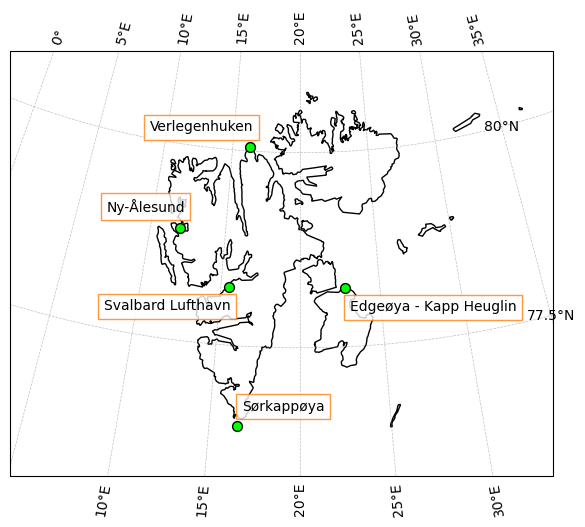

In [3]:
# Location of the weather stations 
map_svalbard_weather_stations()

*Fig. 1: Map of the Svalbard archipelago with the locations and names of the weather stations included in the study.*

#### Reanalyses 

Here, we download 2m temperature and total precipitation from ERA5 and CARRA between 8°E and 30°E and between 76°N and 81°N during the winter days (December-January-February) between December 1990 and February 2022. 

In [4]:
# Parameters
year_start = 1990
year_stop = 2022
area = [81, 8, 76, 30]

# Request
request_dict = {
    "CARRA_analysis": (
        "reanalysis-carra-single-levels",
        {
            "level_type": "surface_or_atmosphere",
            "variable": "2m_temperature",
            "product_type": "analysis",
            "time": [f"{hour:02d}:00" for hour in range(0, 24, 3)],
        },
    ),
    "CARRA_forecast": (
        "reanalysis-carra-single-levels",
        {
            "level_type": "surface_or_atmosphere",
            "variable": "total_precipitation",
            "product_type": "forecast",
            "time": ["00:00", "12:00"],
            "leadtime_hour": ["6", "12", "18"],
        },
    ),
    "ERA5_t2m": (
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": "2m_temperature",
            "time": [f"{hour:02d}:00" for hour in range(24)],
            "area": [82, 8, 75, 40],
        },
    ),
    "ERA5_precip": (
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": "total_precipitation",
            "time": [f"{hour:02d}:00" for hour in range(24)],
            "area": [82, 8, 75, 40],
        },
    ),
}

time_requests = [
    {
        "month": "12",
        "day": [f"{day:02d}" for day in range(1, 32)],
        "year": [str(year) for year in range(year_start, year_stop)],
    },
    {
        "month": ["01", "02"],
        "day": [f"{day:02d}" for day in range(1, 32)],
        "year": [str(year) for year in range(year_start + 1, year_stop + 1)],
    },
]

# Download and transform
datasets = {}
for product, (collection_id, request) in request_dict.items():
    print(f"{product=}")
    if product.startswith("CARRA"):
        for domain in ["east", "west"]:
            print(f"{domain=}")
            datasets[product + "_" + domain] = download.download_and_transform(
                collection_id,
                [
                    request | {"domain": f"{domain}_domain"} | time_request
                    for time_request in time_requests
                ],
                transform_func=utils.regionalise,
                transform_func_kwargs={
                    "lon_slice": slice(area[1], area[3]),
                    "lat_slice": slice(area[2], area[0]),
                },
                chunks={"year": 1},
            )
    elif product.startswith("ERA5"):
        datasets[product] = download.download_and_transform(
            collection_id,
            [request | time_request for time_request in time_requests],
            chunks={"year": 1},
        )
    else:
        raise ValueError(f"{product=}")

product='CARRA_analysis'
domain='east'


100%|██████████| 64/64 [00:15<00:00,  4.06it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_mfdataset(sources, **cached_open_mfdataset_kwargs)
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta

domain='west'


100%|██████████| 64/64 [00:18<00:00,  3.38it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_mfdataset(sources, **cached_open_mfdataset_kwargs)
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta

product='CARRA_forecast'
domain='east'


100%|██████████| 64/64 [00:25<00:00,  2.50it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_mfdataset(sources, **cached_open_mfdataset_kwargs)
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta

domain='west'


100%|██████████| 64/64 [00:21<00:00,  2.97it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_mfdataset(sources, **cached_open_mfdataset_kwargs)
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/c3s_eqc_automatic_quality_control/download.py:625: FutureWarning: In a future version, xarray will not decode the variable 'leadtime' into a timedelta

product='ERA5_t2m'


100%|██████████| 64/64 [00:05<00:00, 12.04it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/utils/kwargs.py:59: UserWarning: In xarray_open_dataset_kwargs backend_kwargs, overriding the default value (squeeze=False) with squeeze=True is not recommended.
  warnings.warn(


product='ERA5_precip'


100%|██████████| 64/64 [00:06<00:00,  9.51it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/utils/kwargs.py:59: UserWarning: In xarray_open_dataset_kwargs backend_kwargs, overriding the default value (squeeze=False) with squeeze=True is not recommended.
  warnings.warn(


(template:section-4)=
### Preparation of 2m temperature and total precipitation

#### Prepare temperature and precipitation from ERA5 and CARRA

The winter-time 2m temperature and total precipitation from ERA5 and CARRA need to be reprocessed to allow for a comparison with observations. This requires the 2m temperature provided by the reanalysis datasets to be daily averaged and converted from K to °C. Furthermore, for simplicity, the 29th of February is also removed from the analysis. 

The total precipitation provided by ERA5 and CARRA is reprocessed to obtain the winter-time daily-aggregated values of precipitation. More precisely, for the reanalysis datasets to be comparable with observations, we compute the total precipitation that accumulated between the time 06:00 of the day under consideration and the time 06:00 of the following day. Furthermore, as with the 2m temperature, we exclude from the analysis the total precipitation corresponding to the 29th of February.

The reprocessing procedure to compute daily-aggregated values of total precipitation differs from ERA5 and CARRA. This is because ERA5 returns values of total precipitation accumulated over a 1-hour period ending at the validity date and time. So, daily-accumulated values are computed by adding up the total precipitation accumulated between the time 06:00 of one day and the time 06:00 of the day after. Instead, CARRA returns total precipitation accumulated since the start time of the forecast, and this is provided for different leadtime hours. For this assessment, we compute daily precipitation with the start times 00:00 and 12:00 and leadtime hours of 6 and 18 hours. 

In [5]:
def daily_temperature_single_reanalysis(da_t2m, year_start, year_stop):
    """
    Given the 2m-temperature from CARRA or ERA5, this function:
        - daily averages the 2m temperature
        - selects the winter days (December-January-February) and excludes the 29th of February 
        - converts the temperature from K to °C

    Parameters
    ----------
    da_t2m : xr.DataArray
        DataArray with either ERA5's or CARRA's 2m temperature over Svalbard. 
        Data have a temporal resolution of 1 hour for ERA5, and 3 hours for CARRA. 

    year_start, year_stop : int, int 
        First and last year considered. 
          
    Returns
    -------
    da_daily_djf_t2m : xr.DataArray
        Either ERA5's or CARRA's daily-averaged 2m temperature over Svalbard in winter. 
        See the function description for information on the reprocessing. 
    """

    # Daily average the 2m temperature 
    da_daily_t2m = da_t2m.resample(forecast_reference_time='1D').mean()
    
    # Only select the winter days (December-January-February) and exclude the 29th of February 
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]

    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]

    da_daily_djf_t2m = da_daily_t2m.sel(forecast_reference_time=dates_no_2902)
    
    # Conversion from K to °C
    da_daily_djf_t2m = da_daily_djf_t2m - 273.15

    return da_daily_djf_t2m 
    

In [6]:
def daily_temperature_reanalyses(dc, year_start, year_stop):
    """
    Given the 2m-temperature from CARRA and ERA5, this function:
        - daily averages the 2m temperature
        - only selects the winter days (December-January-February) and excludes the 29th of February 
        - converts the temperature from K to °C 

    Parameters
    ----------
    dc : dict
        Dictionary with ERA5's and CARRA's 2m temperature and accumulated precipitation over Svalbard.  

    year_start, year_stop : int, int 
        First and last year considered. 
          
    Returns
    -------
    da_era5_t2m, da_carra_west_t2m, da_carra_east_t2m : xr.DataArray
        ERA5's and CARRA's daily-averaged 2m temperature over Svalbard in winter. 
        See the function description for information on the reprocessing.       
    """

    # ERA5
    da_era5_t2m =  daily_temperature_single_reanalysis(dc['ERA5_t2m']['t2m'], year_start, year_stop) 
    
    # CARRA
    da_carra_west_t2m = daily_temperature_single_reanalysis(dc['CARRA_analysis_west']['t2m'], year_start, year_stop)
    da_carra_east_t2m = daily_temperature_single_reanalysis(dc['CARRA_analysis_east']['t2m'], year_start, year_stop)

    # Load datasets
    da_era5_t2m = da_era5_t2m.load()
    da_carra_west_t2m = da_carra_west_t2m.load()
    da_carra_east_t2m = da_carra_east_t2m.load()

    return da_era5_t2m, da_carra_west_t2m, da_carra_east_t2m
    

In [7]:
def daily_precipitation_era5(da_tp, year_start, year_stop):
    """
    This function computes the daily accumulated precipitation for winter (December-January-February) from ERA5.  
    To compute the daily accumulated precipitation, it follows this procedure:
        1) it removes duplicated dates 
           (the timestamp "31/12 at 18:00" appears twice each year in the dataset)
        2) it removes the 30th of Nov of each year 
        3) for each day and at each grid point, it computes the total precipitation that accumulated between the time 06:00 of the 
           day under consideration and the time 06:00 of the following day. This is needed because the weather stations provide
           the precipitation accumulated between time 06:00 of one day and time 06:00 of the following day. 

    Parameters
    ----------
    da_tp : xr.DataArray
        DataArray with accumulated precipitation data over Svalbard as provided by ERA5. 
        Leadtime hours are referenced to time 06:00 and 18:00 of each day. 
        Accumulations are over the hour (the processing period) ending at the forecast step. 
        Units are m. 

    year_start, year_stop : int, int 
        First and last year considered. 
        
    Returns
    -------
    da_daily_djf_tp : xr.DataArray
        ERA5's daily-accumulated precipitation over Svalbard in winter. 
        See the function description for information on the reprocessing. 
        Units are mm. 
    """

    # Remove duplicated dates (needed because the timestamp "31/12 at 18:00" appears twice each year in the dataset)
    da_tp = da_tp.drop_duplicates(dim='forecast_reference_time')

    # Remove 30th of Nov
    nov30_all_years = [datetime.datetime(year, 11, 30, 18) for year in range(year_start, year_stop)]
    da_tp = da_tp.drop(nov30_all_years, dim='forecast_reference_time')

    # Compute daily aggregated precipitation: 
    #     - for each day 
    #     - at each grid point 
    da_daily_tp = da_tp.sum('leadtime').resample(forecast_reference_time='D').sum() 

    # Conversion from m to mm
    da_daily_tp = 1e3 * da_daily_tp 

    # Only select the winter days (December-January-February) and exclude the 29th of February 
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]    
    
    da_daily_djf_tp = da_daily_tp.sel(forecast_reference_time=dates_no_2902)

    return da_daily_djf_tp 


In [8]:
def daily_precipitation_carra(da_tp, year_start, year_stop):
    """
    This function computes the winter-time daily precipitation accumulated between 06 UTC and 06 UTC the next day as provided 
    by CARRA-West or CARRA-East. 
    More precisely, this function: 
        - subtracts values with leadtime 18 and 6
        - separates starting times at midnight and noon 
        - sums the results

    For information on how to compute daily accumulated precipitation, please check the following webpage:  

        - https://confluence.ecmwf.int/pages/viewpage.action?pageId=338485814

    Parameters
    ----------
    da_tp : xr.DataArray
        DataArray with accumulated precipitation data over Svalbard from CARRA. 
        Leadtime hours are referenced to time 00:00 and 12:00 of each day. 
        Accumulations are between the reference time and the ending of each forecast step. 
        Units are mm. 

    year_start, year_stop : int, int 
        First and last year considered. 
            
    Returns
    -------
    da_daily_djf_tp : xr.DataArray
        Either CARRA-West or CARRA-East's daily-accumulated precipitation over Svalbard in winter. 
        See the function description for information on the reprocessing. 
        Units are mm. 
    """ 

    # Subtract values with leadtime 18 and 6    
    da_tp_12h = da_tp.sel(leadtime='18h') - da_tp.sel(leadtime='6h')

    # Separates starting times at midnight and noon 
    da_tp_first_12h = da_tp_12h.where(da_tp_12h['forecast_reference_time'].dt.hour == 0, drop=True)
    da_tp_last_12h = da_tp_12h.where(da_tp_12h['forecast_reference_time'].dt.hour == 12, drop=True)

    da_tp_first_12h['forecast_reference_time'] = pd.to_datetime(da_tp_first_12h['forecast_reference_time'].dt.strftime('%Y-%m-%d'))
    da_tp_last_12h['forecast_reference_time'] = pd.to_datetime(da_tp_last_12h['forecast_reference_time'].dt.strftime('%Y-%m-%d'))
    
    # Sum the results 
    da_daily_tp = da_tp_first_12h + da_tp_last_12h

    # Only select the winter days (December-January-February) and exclude the 29th of February 
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]    
    
    da_daily_djf_tp = da_daily_tp.sel(forecast_reference_time=dates_no_2902)

    return da_daily_djf_tp
    

In [9]:
def daily_precipitation_reanalyses(dc, year_start, year_stop):
    """
    Given the total precipitation from ERA5 and CARRA, this function computes the winter-time daily precipitation accumulated between 
    06 UTC and 06 UTC the next day as provided by ERA5, CARRA-West, and CARRA-East. 

    Parameters
    ----------
    dc : dict
        Dictionary with ERA5's and CARRA's 2m temperature and accumulated precipitation over Svalbard.  

    year_start, year_stop : int, int 
        First and last year considered. 
        
    Returns
    -------
    da_era5_tp, da_carra_west_tp, da_carra_east_tp : xr.DataArray
        ERA5's and CARRA's daily-accumulated precipitation over Svalbard in winter. 
    """

    # ERA5
    da_era5_tp =  daily_precipitation_era5(dc['ERA5_precip']['tp'], year_start, year_stop) 
    
    # CARRA
    da_carra_west_tp = daily_precipitation_carra(dc['CARRA_forecast_west']['tp'], year_start, year_stop)
    da_carra_east_tp = daily_precipitation_carra(dc['CARRA_forecast_east']['tp'], year_start, year_stop)

    # Load datasets
    da_era5_tp = da_era5_tp.load()
    da_carra_west_tp = da_carra_west_tp.load()
    da_carra_east_tp = da_carra_east_tp.load()

    return da_era5_tp, da_carra_west_tp, da_carra_east_tp
    

Daily-averaged temperatures

In [10]:
da_era5_t2m, da_carra_west_t2m, da_carra_east_t2m = daily_temperature_reanalyses(datasets, year_start, year_stop)

Daily-aggregated precipitation

In [11]:
da_era5_tp, da_carra_west_tp, da_carra_east_tp = daily_precipitation_reanalyses(datasets, year_start, year_stop) 

#### Prepare temperature and precipitation from the weather stations

We now store into two pandas dataframes the temperature and total precipitation provided by the weather stations. 

In [12]:
def reformat_weather_station_dataframe(df_sts, name_single_st, year_start, year_stop):
    """
    This function returns daily values of temperature and precipitation, along with the 
    corresponding dates, at a single weather station in Svalbard.
    Use the parameter name_single_st to specify the station of interest.

    This function further filters observations to only consider:
        - the months of December, January, and February, with the exclusion of the 29th of February.  
        - the period over which we downloaded the ERA5's and CARRA's datasets. 
    
    Parameters
    ----------
    df_sts : pd.DataFrame
        It contains name, station ID, time, and daily temperature and precipitation
        for the selected weather stations in Svalbard. 
    
    name_single_st : str
        Name of the weather station to extract.  

    year_start, year_stop : int, int 
        Select observations between 'year_start-12-01' and 'year_stop-02-28'. 
    
    Returns
    -------
    sr_single_st_t2m_djf : pd.Series
        Daily temperature values for the selected station, indexed by time.
        NB: It only includes winter months (Dec, Jan, Feb) with the exclusion of the 29th of February. 

   sr_single_st_tp_djf : pd.Series
       Same as sr_single_st_t2m_djf, but for daily precipitation.     
   """

    # Select weather station 
    df_single_st = df_sts[df_sts['Name'] == name_single_st]
    df_single_st = df_single_st.drop(['Name', 'Station_ID'], axis=1)
    df_single_st = df_single_st.set_index('Time')
    df_single_st.index.name = None

    # Convert index from string to datetime using day-month-year format
    df_single_st.index = pd.to_datetime(df_single_st.index, format="%d.%m.%Y")


    # Ensure dates are sorted because .loc requires a monotonic index.
    # The Ny-Ålesund data are not in chronological order.
    # We use .resample('D').asfreq() instead of .sort_index() because the former
    # fills missing dates with NaNs. This is important since the station datasets
    # omit days with no temperature or precipitation records.
    df_single_st = df_single_st.resample('D').asfreq()

    # Extract temperature and precipitation, as the two variables are dealt with differently 
    sr_single_st_t2m = df_single_st['Daily_temperature']
    sr_single_st_tp = df_single_st['Daily_precipitation']

    # The daily values of precipitation provided by the weather stations are accumulated between 06:00 
    # of given day and 06:00 of the following day. The timestamp associated with the downloaded daily accumulated 
    # precipitation refers to the day when the recording ends.    
    # Here, we modify the timestamps associated to the daily-accumulated precipitation for them to refer to the day 
    # when the recording starts. 
    sr_single_st_tp.index = sr_single_st_tp.index - pd.Timedelta('1D')
    
    # Extend the pd.Series for it to cover all the winter months between 'year_start-12-01' and 'year_stop-02-28'. 
    # The extension is needed because some of the weather stations do not go as back in time as to 'year_start-12-01'. 
    # NaN are placed in locations having no values in the previous index.   
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates_djf = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    sr_single_st_t2m_djf = sr_single_st_t2m.reindex(dates_djf)
    sr_single_st_tp_djf = sr_single_st_tp.reindex(dates_djf)
    
    # Remove 29th of Feburay
    dates_djf_no_2902 = dates_djf[~((dates_djf.month==2) * (dates_djf.day==29))]
    sr_single_st_t2m_djf = sr_single_st_t2m_djf.loc[dates_djf_no_2902]
    sr_single_st_tp_djf = sr_single_st_tp_djf.loc[dates_djf_no_2902]
    
    return sr_single_st_t2m_djf, sr_single_st_tp_djf


def group_weather_stations(year_start, year_stop):
    """
    This function groups into two pd.DataFrames the daily 2m temperature and total precipitation 
    provided by the Svalbard's weather stations in winter between 'year_start-12-01' and 'year_stop-02-28'. 
    
    Parameters
    ----------
    year_start, year_stop : int, int 
        Needed to only select the observations between 'year_start-12-01' and 'year_stop-02-28'

    Returns
    -------
    df_stations_t2m : pd.DataFrame
        Daily-averaged 2m temperature provided by each weather station between 'year_start-12-01' and 'year_stop-02-28'. 

    df_stations_tp : pd.DataFrame
        Same as df_stations_t2m, but for total precipitation. 
        
    """

    # Load the observations and the name of each weather station considered 
    df_sts, names_sts, _, _ = load_weather_stations() 

    sr_edgeoya_t2m, sr_edgeoya_tp = reformat_weather_station_dataframe(df_sts, names_sts[0], year_start, year_stop)
    sr_verlegenhuken_t2m, sr_verlegenhuken_tp = reformat_weather_station_dataframe(df_sts, names_sts[1], year_start, year_stop)
    sr_sorkappoya_t2m, sr_sorkappoya_tp = reformat_weather_station_dataframe(df_sts, names_sts[2], year_start, year_stop)
    sr_ny_alesund_t2m, sr_ny_alesund_tp = reformat_weather_station_dataframe(df_sts, names_sts[3], year_start, year_stop)
    sr_svalbard_lufthavn_t2m, sr_svalbard_lufthavn_tp = reformat_weather_station_dataframe(df_sts, names_sts[4], year_start, year_stop)

    # pd.DataFrames where to store the weather stations 
    df_stations_t2m = pd.DataFrame({names_sts[0]: sr_edgeoya_t2m, 
                                    names_sts[1]: sr_verlegenhuken_t2m, 
                                    names_sts[2]: sr_sorkappoya_t2m, 
                                    names_sts[3]: sr_ny_alesund_t2m, 
                                    names_sts[4]: sr_svalbard_lufthavn_t2m})

    df_stations_tp = pd.DataFrame({names_sts[0]: sr_edgeoya_tp, 
                                   names_sts[1]: sr_verlegenhuken_tp, 
                                   names_sts[2]: sr_sorkappoya_tp, 
                                   names_sts[3]: sr_ny_alesund_tp, 
                                   names_sts[4]: sr_svalbard_lufthavn_tp})

    return df_stations_t2m, df_stations_tp

In [13]:
# Create two pd.DataFrames, one for temperature and the other for total precipitation 
df_stations_t2m, df_stations_tp = group_weather_stations(year_start, year_stop)

(template:section-5)=
### Observational gaps

To analyse temperature, precipitation, and ROS events over Svalbard, we first need to assess the number of missing values in the observations provided by the weather stations (Fig. 2). This evaluation helps determine the period covered by each weather station, and provides a qualitative understanding of whether the gaps in the observations could potentially influence the conclusions of the study. 

Two weather stations, Svalbard Lufthavn and Ny-Ålesund, offer a good coverage of temperature and precipitation over the selected period. The percentage of observations at these two stations surpasses 75% for the majority of the winter seasons, even reaching 100% in numerous occasions. The only exception is at Ny-Ålesund during the 2004/2005 winter season, when the percentage of temperature observations ranges between 25 and 50%. The limited number of observational gaps makes us believe that the missing values might only little affect the estimates of ROS events.  

The other three weather stations do not provide measurements for the total precipitation, but only for the 2m temperature. This means that ROS events can only be studied at Svalbard Lufthavn and Ny-Ålesund. 
However, the temperature observations at these three locations are valuable as they can be used to further evaluate the performace of ERA5 and CARRA. We also note that the remaining weather stations cover a subset of the selected period. The stations at Sørkappøya and Edgeøya - Kapp Heuglin provide, respectively, the shortest and the longest time series. The former starts in the 2010/2011 winter season, while the latter in the 1992/1993 winter season. Furthermore, we note significant gaps in the data collected by these three weather stations. For example, the station at Verlegenhuken has a three-winter gaps between December 2007 and February 2010. 


In [14]:
def obs_percentage_per_djf_in_sts(df_sts_t2m, df_sts_tp, year_start, year_stop):
    """
    This function creates two subplots (one column, two rows).  
    The upper subplot shows the percentage of temperature observations recorded by each weather station 
    for each winter (December-January-February) between 'year_start-12-01' and 'year_stop-02-28'. 
    The lower subplot shows the same, but for precipitation. 

    Parameters
    ----------
    df_sts_t2m, df_sts_tp : pd.DataFrame 
        Daily-averaged 2m temperature and daily-accumulated total precipitation at each of the selected 
        weather stations for each winter day between 'year_start-12-01' and 'year_stop-02-28'.  
    
    year_start, year_stop : int, int 
        First and last year considered.      
    """

    # Load the name of each weather station considered 
    _, names_sts, _, _ = load_weather_stations() 

    n_sts = len(names_sts)
    n_winters = year_stop - year_start

    # Prepare the ticklabels for the x-axis.
    set_xticks_1 = np.array(np.r_[year_start: year_stop], dtype=str)
    set_xticks_2 = np.array(np.r_[year_start+1: year_stop+1], dtype=str)
    set_xticks_1 = [x[2:] for x in set_xticks_1] 
    set_xticks_2 = [x[2:] for x in set_xticks_2] 
    set_xticks = np.char.add(set_xticks_1, '/')
    set_xticks = np.char.add(set_xticks, set_xticks_2)


    # The variable `first_day_decembers` is used to exclude observations from spring (MAM), 
    # summer (JJA), and autumn (SON). This adjustment is necessary because of how we 
    # count observations within each winter season (see later in the function). 
    # Without this, the process would also return counts for other seasons 
    # (which happen to be zero in our case). 
    # Example of `first_day_decembers`:
    # DatetimeIndex(['1990-12-01', '1991-12-01', '1992-12-01', ...])
    first_day_seasons = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='3MS')
    first_day_decembers = first_day_seasons[first_day_seasons.month==12]

    # Plot 
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16,7.5))

    # colormap temperature
    cmap_t2m = plt.cm.Reds
    norm_t2m = colors.BoundaryNorm(np.r_[0:101:25], 210)

    # colormap precipitation 
    cmap_tp = plt.cm.Blues
    norm_tp = colors.BoundaryNorm(np.r_[0:101:25], 210)

    # Run through all the stations 
    for i_st in range(n_sts):

        name_st = names_sts[i_st]
        
        # Temperature subplot
        sr_t2m = df_sts_t2m[name_st]

        # Count the number of observations within each 3-month period (starting from Dec of year_start)
        # Pick only the counts for DJFs 
        n_t2m = sr_t2m.resample('3MS').count()[first_day_decembers]    
        pct_t2m = 100 * n_t2m / 90    # Percentage of observations over each winter
        # Winters with some observational gaps 
        p_t2m = axs[0].scatter(np.r_[0:n_winters][(pct_t2m!=0) * (pct_t2m!=100)], 
                               -i_st*np.ones(n_winters)[(pct_t2m!=0) * (pct_t2m!=100)], c=pct_t2m[(pct_t2m!=0) * (pct_t2m!=100)], 
                               cmap=cmap_t2m, norm=norm_t2m, edgecolor='k', linewidth=0.5,)
        # In black, winters without observational gaps  
        axs[0].scatter(np.r_[0:n_winters][pct_t2m==100], -i_st*np.ones(n_winters)[pct_t2m==100], c='k', edgecolor='k', linewidth=0.5)    
        # In white, winters when no observations were recorded 
        axs[0].scatter(np.r_[0:n_winters][pct_t2m==0], -i_st*np.ones(n_winters)[pct_t2m==0], c='w', edgecolor='k', linewidth=0.5)    

        # Precipitation subplot (same structure as for temperature)
        sr_tp = df_sts_tp[name_st]
        n_tp = sr_tp.resample('3MS').count()[first_day_decembers]
        pct_tp = 100 * n_tp / 90
        p_tp = axs[1].scatter(np.r_[0:n_winters][(pct_tp!=0) * (pct_tp!=100)], 
                              -i_st*np.ones(n_winters)[(pct_tp!=0) * (pct_tp!=100)], c=pct_tp[(pct_tp!=0) * (pct_tp!=100)], 
                              cmap=cmap_tp, norm=norm_tp, edgecolor='k', linewidth=0.5,)
        p_100 = axs[1].scatter(np.r_[0:n_winters][pct_tp==100], -i_st*np.ones(n_winters)[pct_tp==100], c='k', edgecolor='k', linewidth=0.5)
        p_0 = axs[1].scatter(np.r_[0:n_winters][pct_tp==0], -i_st*np.ones(n_winters)[pct_tp==0], c='w', edgecolor='k', linewidth=0.5)
        
    # Set up x- and y-axes 
    ps = [p_t2m, p_tp]
    for i, iax in enumerate(axs):
        iax.set_xticks(np.r_[0:n_winters])
        iax.set_xticklabels(set_xticks, rotation=60)
        iax.set_yticks(np.r_[0:-n_sts:-1])
        iax.set_yticklabels(names_sts)
        cbar = fig.colorbar(ps[i], ax=iax, drawedges=True)
        cbar.set_label('Percentage of observations [%]') 
        cbar.ax.hlines([0, 100], [0, 0], [1, 1], colors=['w', 'k'], linewidth=[8,8])
    
    plt.show() 

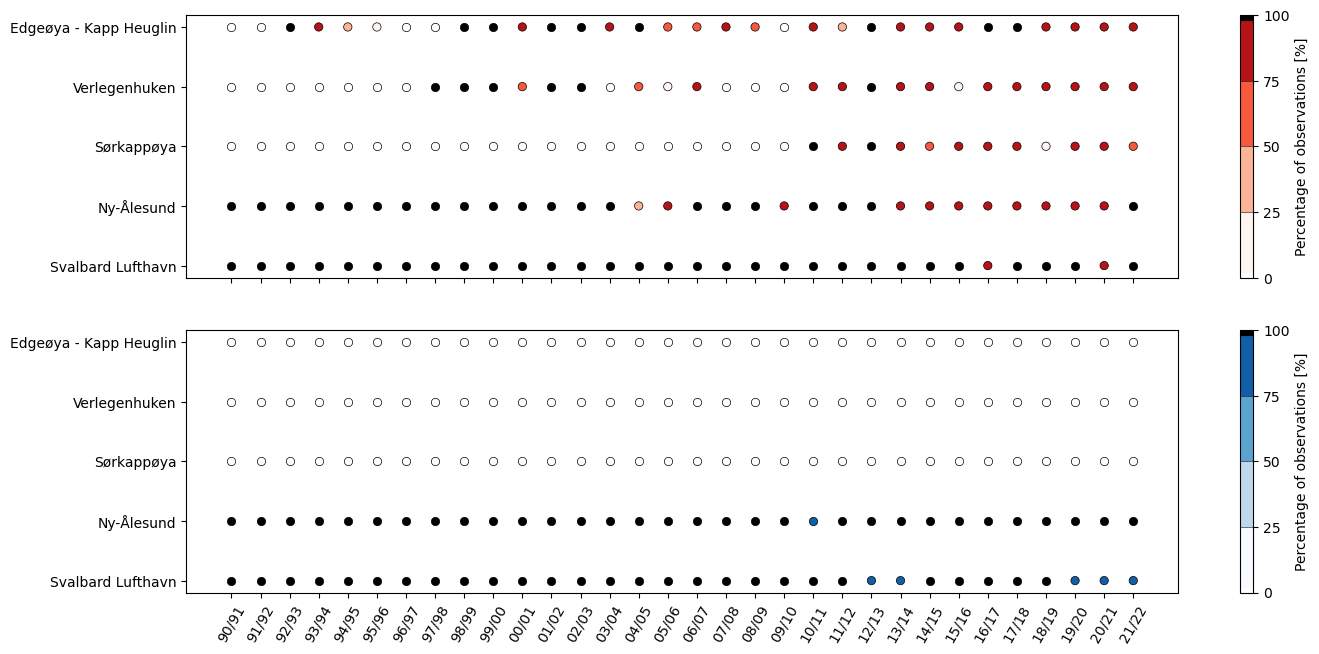

In [15]:
obs_percentage_per_djf_in_sts(df_stations_t2m, df_stations_tp, year_start, year_stop)

*Fig. 2: Percentage of daily observations recorded by each weather station in each winter season (December-January-February, with the exclusion of the 29th of February) between December 1990 and February 2022. The upper plot shows the results for temperature, whereas the lower plot for total precipitation. Empty circles highlight the winter seasons when no observations were recorded, whereas black circles the winter seasons without observational gaps.*

(template:section-6)=
### Reanalyses vs observations: 2m temperature

Fig. 3 reveals a strong linear relationship between the daily-averaged 2m temperature from the weather stations and the reanalysis datasets, therefore suggesting good agreement overall. A closer examination, using both visual inspection and the standard deviation of the differences (STD_diff), indicates that CARRA-West and CARRA-East reproduce the day-to-day variability of 2m temperature better than ERA5 in the region. However, it should be noted, that the biases do not clearly help discriminate among the reanalysis datasets. For instance, ERA5 returns the smallest biases at two stations, Edgeøya - Kapp Heuglin and Verlegenhuken. 

Despite the overall good agreement, the Verlegenhuken weather station stands out as an outlier, as it shows the largest discrepancy between observations and reanalyses. This discrepancy will be discussed below in more detail.   


In [16]:
def dist_from_weather_station(da_reanalysis, lon_st, lat_st):
    """
    Compute the distance (in km) between a given weather station and each grid point 
    of a reanalysis dataset.

    This computation is vectorized (not performed with a for-loop) for efficiency. 
    To achieve this:
        - For ERA5: longitude and latitude (originally 1D arrays) are converted into 
          two 2D NumPy arrays matching the shape of the ERA5 grid.
        - For CARRA-West and CARRA-East: longitude and latitude remain unchanged 
          because they are already 2D.
        - For the weather station: longitude and latitude (two floats) remain unchanged.
  
    Parameters
    ----------
    da_reanalysis : xr.DataArray
        The selected reanalysis dataset (ERA5, CARRA-West, or CARRA-East). 
  
    lon_st, lat_st : float, float
        Longitude and latitude of the weather station. 
        
    Returns
    -------
    d : np.array 
        A 2D array (same shape as `da_reanalysis` spatial grid) containing the 
        distance in kilometers between each grid point and the weather station.  
    """

    r = 6378.137    # Radius of the Earth (in km) 

    # np.arrays containing the longitude and latitude of the reanalysis data. 
    # These are 1D for ERA5, and 2D for CARRA-West and CARRA-East 
    lons_reanalysis = da_reanalysis.longitude.values
    lats_reanalysis = da_reanalysis.latitude.values

    # The 'if' statement checks whether the reanalyis considered is ERA5. 
    # If so, lons_reanalysis and lats_reanalysis are turned into 2D array
    # for them to have the shape of the ERA5's grid 
    if len(lons_reanalysis.shape) == 1:
        lons_reanalysis = np.tile(da_reanalysis.longitude.values, (len(da_reanalysis.latitude), 1))
        lats_reanalysis = np.tile(da_reanalysis.latitude.values, (len(da_reanalysis.longitude), 1)).T

    # Conversion: degrees to radians 
    lons_reanalysis_r = np.deg2rad(lons_reanalysis) 
    lats_reanalysis_r = np.deg2rad(lats_reanalysis) 
    lon_st_r = np.deg2rad(lon_st) 
    lat_st_r = np.deg2rad(lat_st) 

    d = r * np.arccos(np.sin(lats_reanalysis_r)*np.sin(lat_st_r) + np.cos(lats_reanalysis_r)*np.cos(lat_st_r)*np.cos(lons_reanalysis_r-lon_st_r))
    
    return d
    

def reanalysis_data_at_weather_stations(da_reanalysis, lons_sts, lats_sts, names_sts, dates):
    """
    Select daily-averaged 2m temperature or daily-accumulated total precipitation 
    from one of the following reanalysis datasets: ERA5, CARRA-West, or CARRA-East.
    
    The function retrieves the value of temperature or precipitation at the grid 
    point closest to each weather station.

    Parameters
    ----------
    da_reanalysis : xr.DataArray
        3D array 
        Daily-averaged 2m-temperature or daily-accumulated total precipitation from ERA5, CARRA-West, or CARRA-East.  
        
    lons_sts, lats_sts : list, list
        Longitude and latitude of the weather stations.  

    names_sts : np.array
        Names of the selected weather stations. 

    dates : pandas.core.indexes.datetimes.DatetimeIndex
        Dates considered -> Dec, Jan, Feb months between year_start+'-12-01' and year_stop+'-02-28', without the 29th of February 

    Returns
    -------
    df_reanalysis_at_sts : pd.DataFrame
        Values of da_reanalysis at the grid points closest to the weather stations.  
        
    """

    n_sts = len(lons_sts)

    # Arrays where to store the indices of the grid points closest to the weather stations. 
    ind_row_sts = np.nan * np.ones(n_sts)
    ind_col_sts = np.nan * np.ones(n_sts)

    # Run through the weather stations 
    for i_st in range(n_sts):

        # Distance (in km) between the selected weather station and each grid point of the reanalysis dataset 
        d_from_st = dist_from_weather_station(da_reanalysis, lons_sts[i_st], lats_sts[i_st])

        # Row and column indices of the grid point closest to the weather station  
        ind_row_sts[i_st] = np.argmin(d_from_st)//d_from_st.shape[1]
        ind_col_sts[i_st] = np.argmin(d_from_st)%d_from_st.shape[1]

    # Select the values of da_reanalysis at each specific par (ind_row_sts[i_st], ind_col_sts[i_st]) location 
    # with i_st ranging from 0 to n_sts (excluded) 
    da_ind_row_sts = xr.DataArray(ind_row_sts, dims=['Weather stations']).astype(dtype=int)
    da_ind_col_sts = xr.DataArray(ind_col_sts, dims=['Weather stations']).astype(dtype=int)
    da_reanalysis_at_sts = da_reanalysis[:, da_ind_row_sts, da_ind_col_sts]

    df_reanalysis_at_sts = pd.DataFrame(da_reanalysis_at_sts.values, index=dates, columns=names_sts)
    
    return df_reanalysis_at_sts 


def values_at_single_station(df_stations, df_era5_at_sts, df_carra_west_at_sts, df_carra_east_at_sts, name_st):
    """
    Select either the 2m temperature or total precipitation for a given weather station, 
    then create two pandas DataFrames:
    
    1. The first DataFrame stores the values from the weather station alongside the
       corresponding values from ERA5, CARRA-West, and CARRA-East.
    2. The second DataFrame stores the differences between the values provided by each 
       reanalysis dataset and by the weather station.  

    Parameters
    ----------
    df_stations : pd.DataFrame
        Timeseries of either the 2m temperature or the total precipitation provided by a weather station. 

    df_era5_at_sts : pd.DataFrame
        Timeseries of either the 2m temperature or the total precipitation provided by ERA5 at the grid point closest to each weather station. 

    df_carra_west_at_sts : pd.DataFrame
        Same as df_era5_at_sts, but for CARRA-West. 
        
    df_carra_east_at_sts : pd.DataFrame
        Same as df_era5_at_sts, but for CARRA-East. 

    name_st : str
        Name of the selected weather station.  

    Returns
    -------
    df_st : pd.DataFrame 
        Time series, for the selected weather station, of either 2m temperature 
        or total precipitation from the station itself and from the reanalysis datasets 
        (ERA5, CARRA-West, and CARRA-East) at the nearest grid point.  

    df_diff_st : pd.DataFrame
        Time series of differences between each reanalysis dataset and the weather station's observations. 
        
    """

    # We select one weather station. We store into an individual pd.DataFrame either the 2m temperature or the 
    # total precipitation provided by the weather station and by the reanalysis datasets at the grid point 
    # closest to the station. 
    df_st = pd.DataFrame({'Weather station': df_stations[name_st], 
                          'ERA5': df_era5_at_sts[name_st], 
                          'CARRA-West': df_carra_west_at_sts[name_st], 
                          'CARRA-East': df_carra_east_at_sts[name_st]})


    # Compute the difference between each reanalysis dataset (ERA5, CARRA-West, CARRA-East) 
    # and the weather station observations: (reanalysis − station).
    df_diff_st = df_st.assign(**df_st[['ERA5', 'CARRA-West', 'CARRA-East']].sub(df_st['Weather station'], axis=0).add_prefix(''))
    
    return df_st, df_diff_st 


def values_at_all_stations(df_stations_t2m, df_stations_tp, da_era5_t2m, da_era5_tp, da_carra_west_t2m, da_carra_west_tp, da_carra_east_t2m, da_carra_east_tp, year_start, year_stop):
    """
    Extend the functionality of "values_at_single_station" to all weather stations. 
    Furthermore, this function processes both the 2m tempetature and the total precipitation, storing 
    the results into individual python dictionaries: 
        - One dictionary contains pandas DataFrames for 2m temperature.
        - The other contains pandas DataFrames for total precipitation.

    Parameters
    ----------
    df_stations_t2m : pd.DataFrame
        Daily-averaged 2m temperature provided by the weather stations. 
    
    df_stations_t2p : pd.DataFrame
        Daily-accumulated total precipitation provided by the weather stations. 

    da_era5_t2m, da_era5_tp : xr.DataArray
        3D array 
        2m-temperature and daily precipitation from ERA5. 

    da_carra_west_t2m, da_carra_west_tp : xr.DataArray
        Same as da_era5_t2m and da_era5_tp, but for CARRA-West. 

    da_carra_east_t2m, da_carra_east_tp : xr.DataArray
        Same as da_era5_t2m and da_era5_tp, but for CARRA-East. 

    year_start, year_stop : int, int 
        First and last year considered. 
        
    Returns
    -------
    dc_t2m_at_sts : dict
        For each weather station, we store into a pd.DataFrame the timeseries of 2m temperature provided by the weather station and 
        by the reanalysis datasets at the grid point closest to the station. Then, we store the pd.DataFrame for each weather
        station into a python dictonary. 

    dc_diff_t2m_at_sts : dict
        For each weather station, we also store into a pd.DataFrame the difference between the 2m temperature provided by each 
        reanalysis dataset and the weather station. Then, we store the pd.DataFrame for each weather station into a python dictonary. 
    
    dc_tp_at_sts : dict
        Same as dc_t2m_at_sts, but for total precipitation. 
    
    dc_diff_tp_at_sts : dict
        Same as dc_diff_t2m_at_sts, but for total precipitation. 

    """

    # Load names and coordindates of the selected weather stations   
    _, names_sts, lons_sts, lats_sts = load_weather_stations() 

    # Only select winter days (December-January-February) between 'year_start-12-01' and 'year_stop-02-28' (without the 29th of February)
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))] 
    
    # For each reanalysis dataset, extract the 2m temperature and total precipitation at the grid point closest to each weather station 
    # - ERA5
    df_era5_t2m_at_sts = reanalysis_data_at_weather_stations(da_era5_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_era5_tp_at_sts = reanalysis_data_at_weather_stations(da_era5_tp, lons_sts, lats_sts, names_sts, dates_no_2902)

    # - CARRA-West
    df_carra_west_t2m_at_sts = reanalysis_data_at_weather_stations(da_carra_west_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_carra_west_tp_at_sts = reanalysis_data_at_weather_stations(da_carra_west_tp, lons_sts, lats_sts, names_sts, dates_no_2902)

    # - CARRA-East 
    df_carra_east_t2m_at_sts = reanalysis_data_at_weather_stations(da_carra_east_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_carra_east_tp_at_sts = reanalysis_data_at_weather_stations(da_carra_east_tp, lons_sts, lats_sts, names_sts, dates_no_2902)


    # For each weather station:
    #   1. Create a pandas DataFrame with the time series of 2m temperature from the weather station 
    #      and from the reanalysis datasets (ERA5, CARRA-West, CARRA-East) at the nearest grid point.
    #      Store each DataFrame in a Python dictionary.
    #   2. Create another DataFrame with the differences between each reanalysis dataset and the weather 
    #      station observations.  
    #      Store these in a separate dictionary.
    # Repeat the same procedure for total precipitation.
    dc_t2m_at_sts = dict()
    dc_tp_at_sts = dict()
    dc_diff_t2m_at_sts = dict()
    dc_diff_tp_at_sts = dict()

    for name_st in names_sts:
        dc_t2m_at_sts[name_st], dc_diff_t2m_at_sts[name_st] = values_at_single_station(df_stations_t2m, df_era5_t2m_at_sts, df_carra_west_t2m_at_sts, df_carra_east_t2m_at_sts, name_st)
        dc_tp_at_sts[name_st], dc_diff_tp_at_sts[name_st] = values_at_single_station(df_stations_tp, df_era5_tp_at_sts, df_carra_west_tp_at_sts, df_carra_east_tp_at_sts, name_st)

    return dc_t2m_at_sts, dc_diff_t2m_at_sts, dc_tp_at_sts, dc_diff_tp_at_sts


In [17]:
def plots_t2m(dc_t2m_at_sts, dc_diff_t2m_at_sts):
    """
    Create a figure with five rows (one per weather station) and three columns (ERA5, CARRA-West, and CARRA-East).
    
    Each row contains three scatter plots:
        - Left: compares daily-averaged 2m temperature from the weather station (x-axis) with ERA5 (y-axis).
        - Middle: compares the weather station with CARRA-West.
        - Right: compares the weather station with CARRA-East.

    Parameters
    ----------
    dc_t2m_at_sts : dict
        A dictionary where each key corresponds to a weather station and each value 
        is a pandas DataFrame containing 2m temperature time series from the weather 
        station and from ERA5, CARRA-West, and CARRA-East at the nearest grid point
    
    dc_diff_t2m_at_sts : dict
        A dictionary where each key corresponds to a weather station and each value 
        is a pandas DataFrame containing the difference between the 2m temperature from 
        each reanalysis dataset and the weather station.   
    
    """ 

    # Load the names of each weather station considered 
    _, names_sts, _, _ = load_weather_stations() 
    
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(25,30)) 

    # Run through all the weather stations
    for i_st, name_st in enumerate(names_sts):
    
        names_reanalysis = ['ERA5', 'CARRA-West', 'CARRA-East']
        color_col = ['C0', 'C1', 'C2']
        for i_col in range(3):
            axs[i_st,i_col].scatter(dc_t2m_at_sts[name_st]['Weather station'], dc_t2m_at_sts[name_st][names_reanalysis[i_col]], alpha=0.6, c=color_col[i_col])
            axs[i_st,i_col].plot([-40,10], [-40,10], c='gray', lw=0.5, ls='--')

            # Compute the bias and the standard deviation of the difference. Show them in a box at the bottom right of each subplot. 
            bias =  dc_diff_t2m_at_sts[name_st][names_reanalysis[i_col]].mean()
            std_diff = dc_diff_t2m_at_sts[name_st][names_reanalysis[i_col]].std()
            axs[i_st,i_col].text(0.50, 0.05, 'bias=' + str(round(bias, 2)) + ',   ' + 'STD_diff=' + str(round(std_diff, 2)), transform=axs[i_st,i_col].transAxes, fontsize=14, 
                                 bbox=dict(facecolor='w', edgecolor=color_col[i_col], alpha=0.8))
        
        axs[i_st,1].set_title(name_st, fontsize=16)

    # Set x- and y-labels. 
    for i, iax in enumerate(axs.flatten()):
        iax.grid()
        if i%3==0:
            iax.set_ylabel('reanalysis [°C]')
        if i>=12:
            iax.set_xlabel('weather station [°C]')
        
    plt.show() 

In [18]:
dc_t2m_at_sts, dc_diff_t2m_at_sts, dc_tp_at_sts, dc_diff_tp_at_sts = \
    values_at_all_stations(df_stations_t2m, df_stations_tp, da_era5_t2m, da_era5_tp, da_carra_west_t2m, da_carra_west_tp, da_carra_east_t2m, da_carra_east_tp, year_start, year_stop)

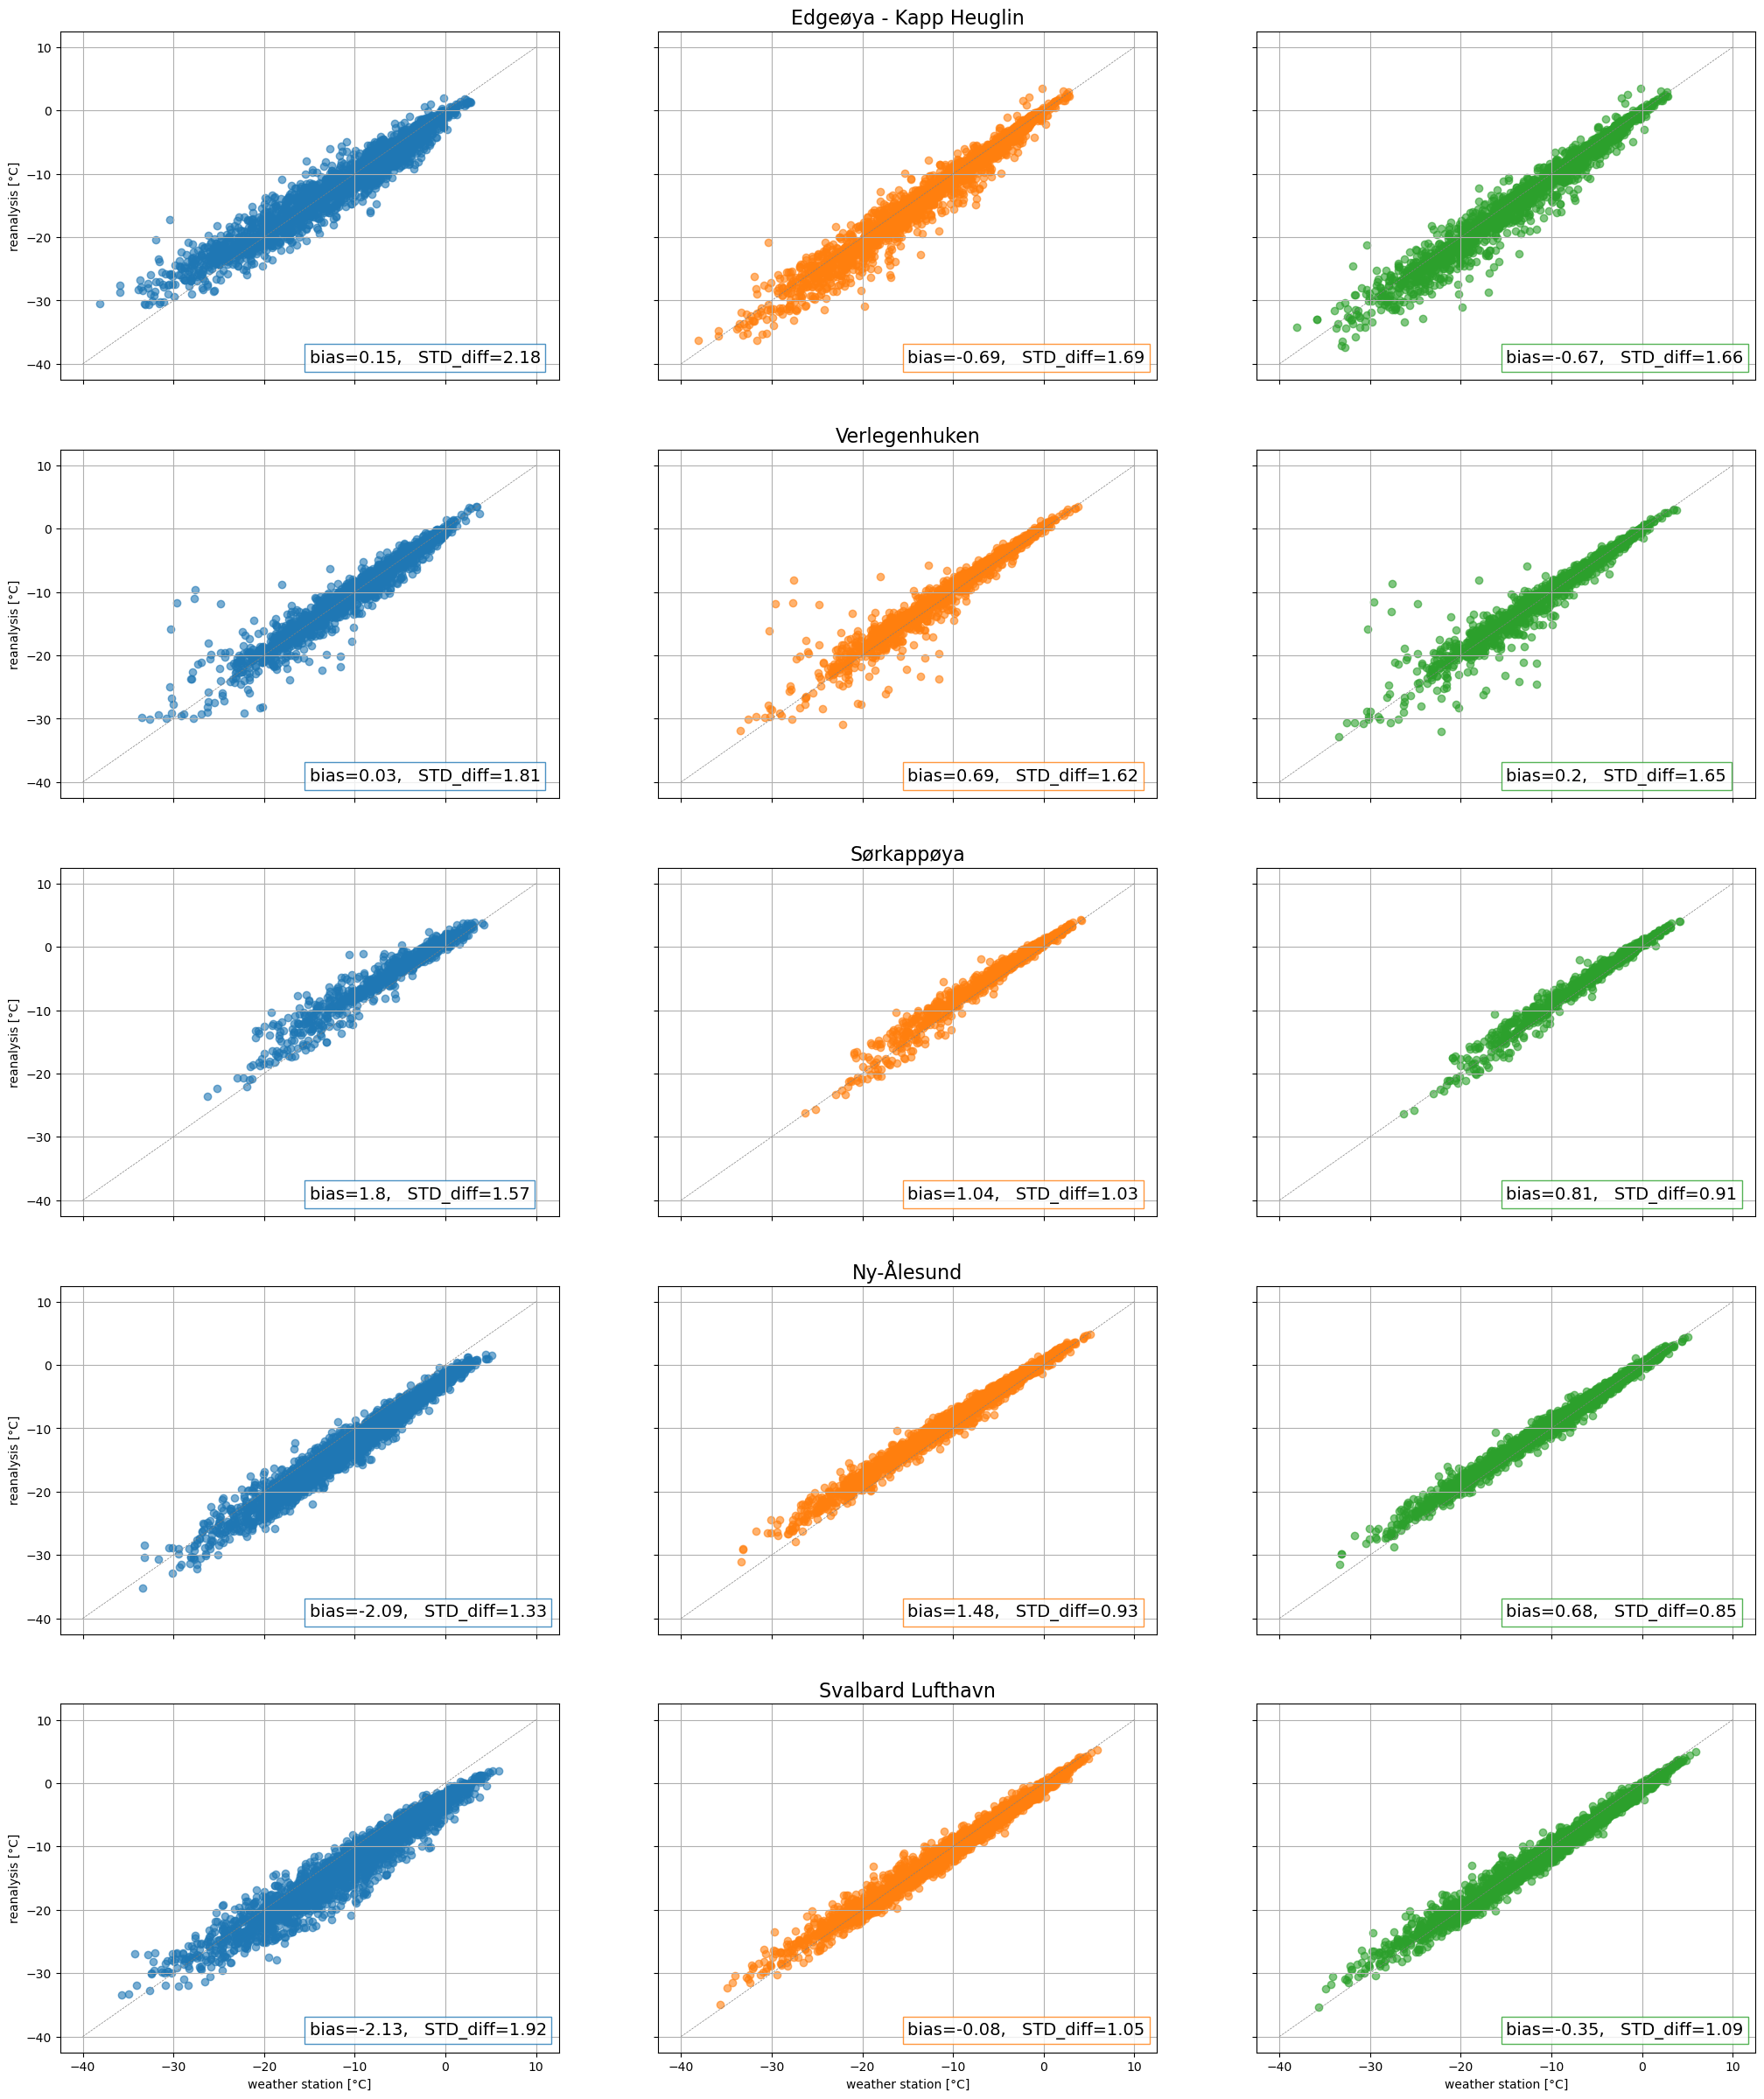

In [19]:
plots_t2m(dc_t2m_at_sts, dc_diff_t2m_at_sts)


*Fig. 3: Comparison between the 2m-temperature from each weather station and the reanalysis datasets. The figure is organized in fifteen scatter plots, arranged in five rows and three columns. The left column compares the 2m temperature data from each weather station (x-axis) and ERA5 (y-axis). The middle and right columns show the comparisons with CARRA-West and CARRA-East, respectively. Each plot also reports the corresponding bias and standard deviation of the difference.*

Fig. 4 provides information on the differences between the 2m temperature from reanalyses and observations at the Verlegenhuken weather station. The upper subplot in Fig. 4 shows that the 2m temperature observed by the Verlegenhuken weather station diverges the most from CARRA-East during the 1997/1998 winter season. The magnitude of the differences, of almost 20°C, lets us suppose this winter season to be mostly responsible for the outliers shown in Fig. 3. 

The lower subplots, which focus on the 1997/1998 winter season, clearly show the discrepancy occurring during the first twenty days of February 1998. It’s worth noting that such a discrepancy occurs irrespective of the reanalysis datases, which are able to reproduce the local maximum in temperature, but with a lag of approximately 10 days. A more comprehensive analysis would be needed to understand the reasons behind this discrepancy. However, such analysis falls outside the scope of this work. 


In [20]:
def show_t2m_difference_at_verlegenhuken(dc_t2m_at_sts, dc_diff_t2m_at_sts):
    """
    This function shows the anomalously high temperature difference between the Verlegenhuken weather 
    station and the reanalysis datasets in February 1998. 
    The function creates 4 subplots. One subplot fills the entire upper row, while the lower row is equally 
    split among the remaining three subplots. The upper subplot shows results for the entire period when the 
    Verlegenhuken weather station observed the 2m temperature, and shows the difference between the 2m 
    temperature from CARRA-East and the Verlegenhuken weather station. The plot shows results from CARRA-East, 
    but it could as well have shown results from ERA5 or CARRA-West. 
    The lower subplots show the 2m temperature at Verlegenhuken as provided by the weather station and by
    each reanalysis dataset (a subplot per reanalysis) between December 1997 and February 1998. 

    Parameters
    ----------
    dc_t2m_at_sts : dict
        A dictionary where each key corresponds to a weather station and each value 
        is a pandas DataFrame containing 2m temperature time series from the weather 
        station and from ERA5, CARRA-West, and CARRA-East at the nearest grid point. 
    
    dc_diff_t2m_at_sts : dict
        A dictionary where each key corresponds to a weather station and each value 
        is a pandas DataFrame containing the difference between the 2m temperature from 
        each reanalysis dataset and a weather station.    
        
    """

    fig = plt.figure(figsize=(25,10)) 

    # Create 4 subplots over two rows.
    gs = fig.add_gridspec(2, 3)
    ax0 = fig.add_subplot(gs[0,:])    # create upper subplot (it occupies the entire row)
    ax10 = fig.add_subplot(gs[1,0])   # create the lower subplots
    ax11 = fig.add_subplot(gs[1,1])
    ax12 = fig.add_subplot(gs[1,2])
    axs = [ax0, ax10, ax11, ax12]

    # Upper subplot
    dc_diff_t2m_at_sts['Verlegenhuken']['CARRA-East'].plot(ax=ax0, label='2m temperature difference between CARRA-East and the weather station')

    # Lower subplots 
    dc_t2m_at_sts['Verlegenhuken'][['Weather station', 'ERA5']].loc['1997-12-01':'1998-02-28'].plot(ax=ax10)
    dc_t2m_at_sts['Verlegenhuken'][['Weather station', 'CARRA-West']].loc['1997-12-01':'1998-02-28'].plot(ax=ax11)
    dc_t2m_at_sts['Verlegenhuken'][['Weather station', 'CARRA-East']].loc['1997-12-01':'1998-02-28'].plot(ax=ax12)

    for iax in axs:
        iax.grid() 
        iax.legend() 
        iax.set_ylabel('[°C]')
    
    plt.show()    


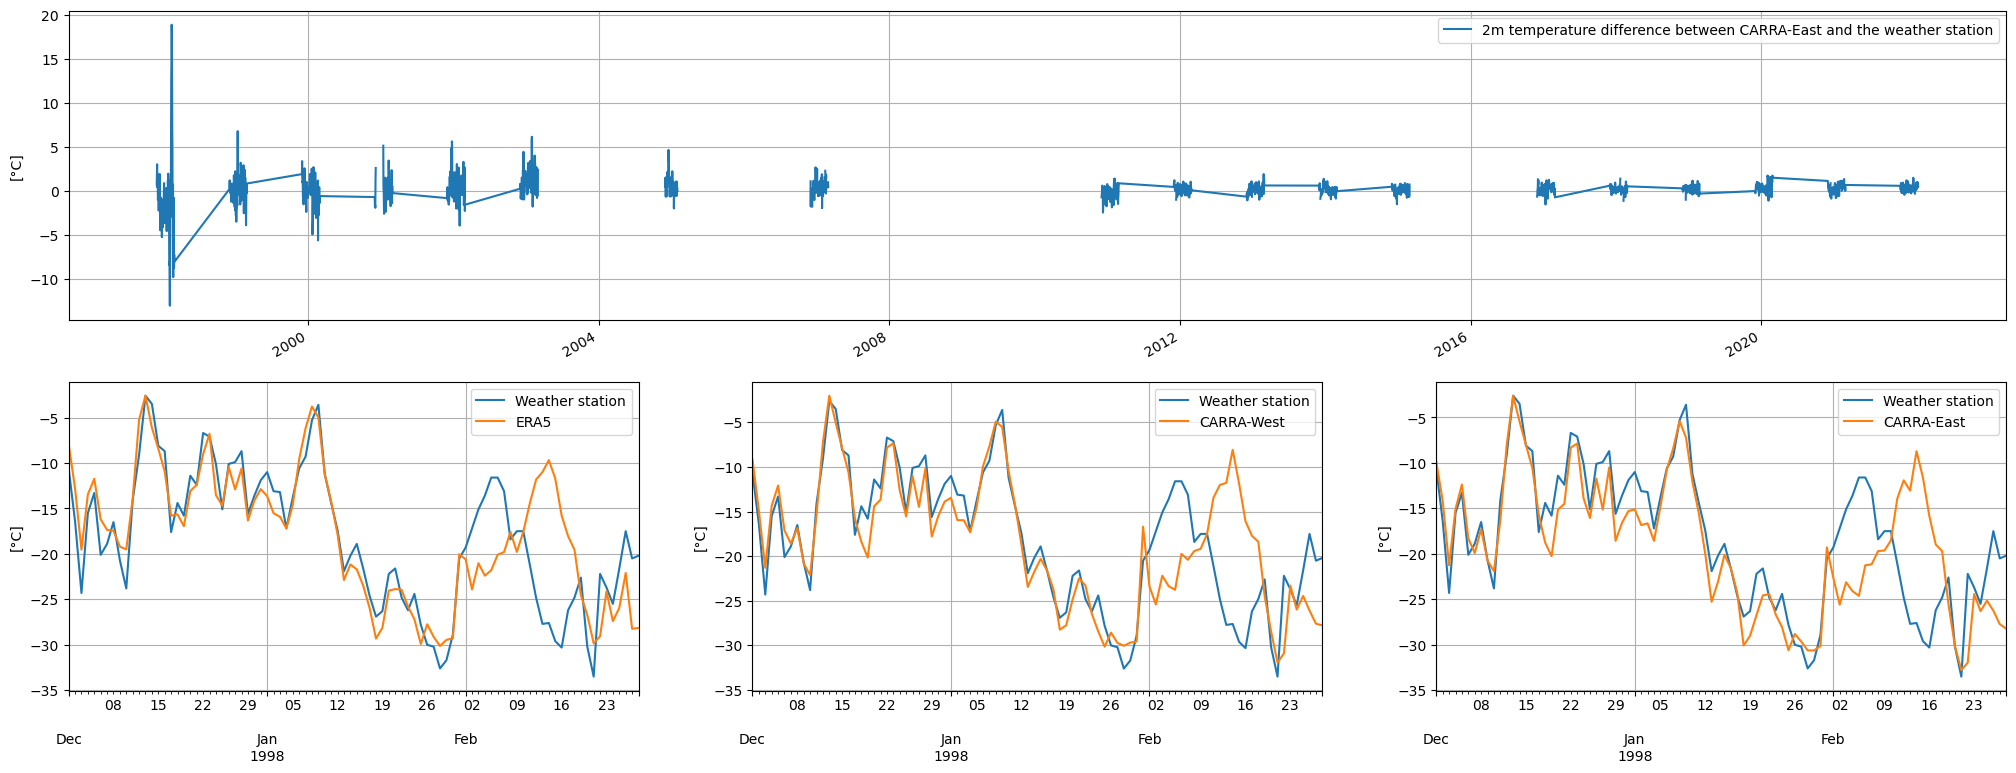

In [21]:
show_t2m_difference_at_verlegenhuken(dc_t2m_at_sts, dc_diff_t2m_at_sts)


*Fig. 4: Comparison between the 2m temperature at the Verlegenhuken weather station and the reanalysis datasets. The upper subplot shows results for the entire period when the Verlegenhuken weather station observed 2m temperature, while the lower subplots focus on the 1997/1998 winter season. The upper subplot shows the difference between the 2m temperature from CARRA-East at the grid point closest to the weather station and from the Verlegenhuken weather station. The lower subplots show the 2m temperature observed by the weather station (in blue) and provided by the reanalysis datasets at the grid point closest to the weather station (in orange). The subplot on the left shows the results for ERA5, the one in the middle for CARRA-West, and the one on the right for CARRA-East.*

(template:section-7)=
### Reanalyses vs observations: total precipitation

As with the 2m temperature, we note a linear relationship between the daily-accumulated precipitation from the weather stations and from ERA5, CARRA-West and CARRA-East (Fig. 5). The analysis of the bias and the standard deviation of the differences indicates that CARRA-West and CARRA-East better agree with the observations when compared to ERA5. However, this same analysis does not discrimintate between CARRA-West and CARRA-East which, instead, return comparable results. 


In [22]:
def plots_tp(dc_tp_at_sts, dc_diff_tp_at_sts):
    """
    This function creates a figure with two rows and three columns. It only has two rows because the total precipitation 
    is only provided by two of the selected weather stations over Svalbard (Ny-Ålesund and Svalbard Lufthavn).  
    Each row is made of three scatter plots. The scatter plot on the left is used to 
    compare the total precipitation from the weather station (x-axis) and from ERA5 (y-axis). 
    The plots in the middle and on the right follow the same structure, but show the 
    comparison with CARRA-West and CARRA-East respectively. 

    Parameters
    ----------
    dc_tp_at_sts : dict
        Each element of the dict consists of a pd.DataFrame and refers to a weather station.  
        This contains the total precipitation from the weather station, ERA5, CARRA-West, and CARRA-East.  
    
    dc_diff_tp_at_sts : dict
        Each element of the dict consists of a pd.DataFrame and refers to a weather station.  
        The pd.DataFrame contains the difference between the total precipitation from 
        each reanalysis dataset and the weather station.   
       
    """

    # Load the names of each weather station considered 
    _, names_sts, _, _ = load_weather_stations() 
    
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(25,10)) 
    
    # Run through the two weather stations for which total precipitation is provided.  
    for i_st, name_st in enumerate(names_sts[-2:]):
    
        names_reanalysis = ['ERA5', 'CARRA-West', 'CARRA-East']
        color_col = ['C0', 'C1', 'C2']
        for i_col in range(3):
            axs[i_st,i_col].scatter(dc_tp_at_sts[name_st]['Weather station'], dc_tp_at_sts[name_st][names_reanalysis[i_col]], alpha=0.2, s=5, c=color_col[i_col])
            axs[i_st,i_col].plot([0,100], [0,100], c='gray', lw=0.5, ls='--')
            
            # Compute the bias and the standard deviation of the difference. Show them in a box at the bottom right of each subplot. 
            bias =  dc_diff_tp_at_sts[name_st][names_reanalysis[i_col]].mean()
            std_diff = dc_diff_tp_at_sts[name_st][names_reanalysis[i_col]].std()
            axs[i_st,i_col].text(0.5, 0.05, 'bias=' + str(round(bias, 2)) + ',   ' + 'STD_diff=' + str(round(std_diff, 2)), transform=axs[i_st,i_col].transAxes, fontsize=14, 
                                 bbox=dict(facecolor='w', edgecolor=color_col[i_col], alpha=0.8))
         
        axs[i_st,1].set_title(name_st, fontsize=16)
        
    # Set x- and y-labels. 
    for i, iax in enumerate(axs.flatten()):
        iax.grid()
        if i%3==0:
            iax.set_ylabel('reanalysis [mm]')
        if i>=3:
            iax.set_xlabel('weather station [mm]')
    
    plt.show() 

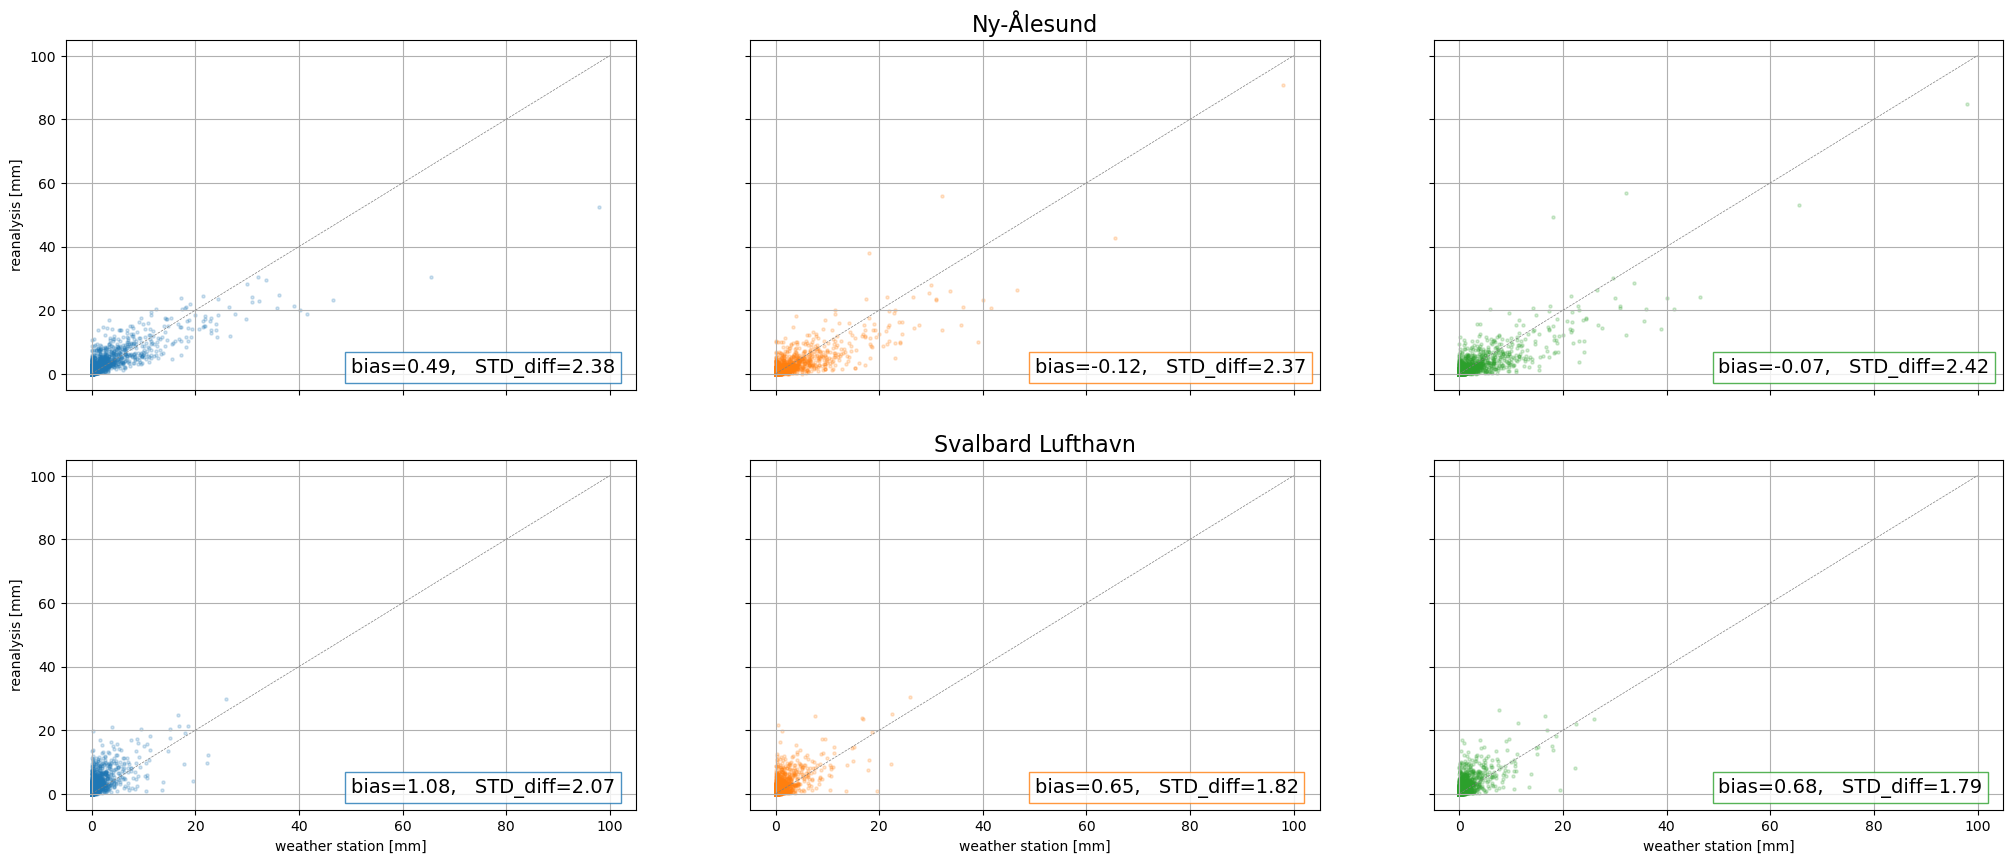

In [23]:
plots_tp(dc_tp_at_sts, dc_diff_tp_at_sts)


*Fig. 5: Comparison between the daily-accumulated total precipitation from the weather stations and the reanalysis datasets at the grid points closest to the weather stations. This figure follows the same structure as Fig. 4, but only presents the results for Ny-Ålesund and Svalbard Lufthavn because the total precipitation is not provided at the other three locations.*

(template:section-8)=
### Reanalyses vs observations: rain-on-snow events

The differences between the reanalysis datasets become more evident when we compare the winter-time number of ROS events identified by the reanalysis datasets and by the weather stations. This comparison is based on visual inspection (Fig. 6), and on the absolute difference between the winter-time number of ROS events between observations and each reanalysis dataset (Table 1). Before describing the results, though, it is important to note that, to allow a comparison with the observations, the reanalysis datasets are artificially masked for them to match the gaps in the observations. 

The comparison with the observational data indicates that CARRA reproduces the winter-time number of ROS events over Svalbard more accurately than ERA5, with CARRA-East performing better than CARRA-West. This result is in line with the [CARRA User Guide](https://confluence.ecmwf.int/display/CKB/Copernicus+Arctic+Regional+Reanalysis+%28CARRA%29%3A+Data+User+Guide), which recommends CARRA-East for Svalbard as the archipelago is located at a short distance from the boundary of CARRA-West. However, we also note that the performance of ERA5, CARRA-West, and CARRA-East depends on the weather station. 

At Ny-Ålesund, simple visual inspection indicates that CARRA-East better reproduces the winter-to-winter variations in the number of ROS events. Instead, CARRA-West and ERA5 tend to overestimate and underestimate this number, respectively. The issue with ERA5 might be due to the reanalysis data providing lower values of 2m temperature at Ny-Ålesund when compared to observations, as shown in Fig. 3. 

Fig. 6 and Table 1 also seem to indicate that CARRA-West and CARRA-East better reproduce the winter-to-winter variations of ROS events at Svalbard Lufthavn. Indeed, while CARRA-West and CARRA-East return comparable results, they both show an overall smaller discrepancy with the observations when compared to ERA5. For instance, the averaged absolute difference of the number of ROS events from observations and ERA5 is approximately 1.8, whereas it is 1.2 for CARRA-West, and 1.0 for CARRA-East (Table 1). It is worth noting, however, that this conclusion is not as clear as for Ny-Ålesund, as both CARRA-West and CARRA-East tend to overestimate the number the ROS events at Svalbard Lufthavn, while ERA5 tends to underestimate it. 


In [24]:
def monthly_ros_events_at_single_station(df_t2m, df_tp, year_start, year_stop):
    """
    This function counts the number of rain-on-snow (ROS) events per winter at the location of one 
    weather station using the daily-averaged 2m temperature and the daily-accumulated total precipitation 
    provided by:
        - the weather station 
        - ERA5
        - CARRA-West
        - CARRA-East 

    Rain-on-snow events defined as: 
        - daily-averaged temperature > 0 °C
        - daily-accumulated total precipitation > 1 mm

    To allow for a comparison with the weather stations, we artificially fill the reanalysis data with the same 
    gaps as in the observations. 
        
    Parameters
    ----------
    df_t2m : pd.DataFrame
        Daily-averaged 2m-temperature provided by the selected weather station and each reanalysis dataset in winter.  

    df_tp : pd.DataFrame
        Daily-accumulated total precipitation provided by the selected weather station and each reanalysis dataset in winter.   
 
    year_start, year_stop : int, int 
        First and last year considered. 
    
    Returns
    -------
    df_n_ros : pd.DataFrame
        Total number of ROS events for each winter season.  
    
    """

    df_t2m = df_t2m[['Weather station', 'ERA5', 'CARRA-West', 'CARRA-East']]
    df_tp = df_tp[['Weather station', 'ERA5', 'CARRA-West', 'CARRA-East']]

    # Artificially fill the reanalysis data with the same gaps as in the observations
    df_t2m.loc[df_t2m.isnull().any(axis=1), :] = np.nan
    df_tp.loc[df_tp.isnull().any(axis=1), :] = np.nan
    
    # Rain-on-snow events
    df_ros = (df_t2m>0) * (df_tp>1)

    # The variable `first_day_decembers` is used to exclude observations from spring (MAM), 
    # summer (JJA), and autumn (SON). This adjustment is necessary because of how we 
    # count observations within each winter season (see later in the function). 
    # Without this, the process would also return counts for other seasons 
    # (which happen to be zero in our case). 
    # Example of `first_day_decembers`:
    # DatetimeIndex(['1990-12-01', '1991-12-01', '1992-12-01', ...])   
    first_day_seasons = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='3MS')
    first_day_decembers = first_day_seasons[first_day_seasons.month==12]
    
    df_n_ros = df_ros.resample('3MS').sum()
    df_n_ros  = df_n_ros.loc[first_day_decembers]
    
    return df_n_ros 


def plot_ros_events(df_n_ros_ny_alesund, df_n_ros_svalbard_lufthavn):
    """
    This function generates a figure showing the number of ROS events per winter season based on observations 
    and reanalysis datasets (ERA5, CARRA-West, and CARRA-East) for Ny-Ålesund and Svalbard Lufthavn. 
    The function also computes and shows the corresponding linear regression lines. 
    
    The figure consists of two stacked subplots:
        - Top subplot -> results for Ny-Ålesund.
        - Bottom subplot -> results for Svalbard Lufthavn.
    
    Parameters
    ----------
    df_n_ros_ny_alesund : pd.DataFrame
        Total number of ROS events for each winter season at Ny-Ålesund as provided by the 
        weather station and each reanalysis dataset.   

    df_n_ros_svalbard_lufthavn : pd.DataFrame
        Total number of ROS events for each winter season at Svalbard Lufthavn as provided by the 
        weather station and each reanalysis dataset.  
    """

    # Load the names of each weather station considered 
    _, names_sts, _, _ = load_weather_stations() 

    # Compute linear regression line (the function is defined in the cell below) 
    df_n_ros_reg_lines_ny_alesund = linear_regression_lines_ros_single_station(df_n_ros_ny_alesund)    
    df_n_ros_reg_lines_svalbard_lufthavn = linear_regression_lines_ros_single_station(df_n_ros_svalbard_lufthavn)
    
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,10))

    df_n_ros_ny_alesund.plot(ax=axs[0], style=['-', '--', '-.', ':'], lw=2, color=['C0', 'C1', 'C2', 'C3'])
    df_n_ros_svalbard_lufthavn.plot(ax=axs[1], style=['-', '--', '-.', ':'], lw=2, color=['C0', 'C1', 'C2', 'C3'])

    df_n_ros_reg_lines_ny_alesund.plot(ax=axs[0], style=['-', '--', '-.', ':'], color=['C0', 'C1', 'C2', 'C3'], legend=False)
    df_n_ros_reg_lines_svalbard_lufthavn.plot(ax=axs[1], style=['-', '--', '-.', ':'], color=['C0', 'C1', 'C2', 'C3'], legend=False)
    
    for i, iax in enumerate(axs):
        iax.grid()
        iax.set_ylabel('N° ROS events')
        iax.set_title(names_sts[-2:][i])
    
    plt.show()

    
def abs_diff_n_ros_single_station(df_n_ros, name_st):
    """
    This function calculates the average absolute difference in the number of ROS events between observations and reanalysis datasets 
    at the selected weather station over the entire period.

    Parameters
    ----------
    df_n_ros : pd.DataFrame 
        Total number of ROS events for each winter season.  

    name_st : str 
        Name of the weather station of interest

    Returns
    -------
    df_abs_diff_n_ros : pd.DataFrame 
        Average absolute difference in the number of ROS events between observations and reanalysis datasets 
        at the selected weather station over the entire period. 
    """

    dc_abs_diff_n_ros = {}
    
    dc_abs_diff_n_ros['ERA5'] = np.round(np.mean(np.abs(df_n_ros['ERA5'] - df_n_ros['Weather station'])), 1)
    dc_abs_diff_n_ros['CARRA-West'] = np.round(np.mean(np.abs(df_n_ros['CARRA-West'] - df_n_ros['Weather station'])), 1)
    dc_abs_diff_n_ros['CARRA-East'] = np.round(np.mean(np.abs(df_n_ros['CARRA-East'] - df_n_ros['Weather station'])), 1)

    df_abs_diff_n_ros = pd.DataFrame.from_dict(dc_abs_diff_n_ros, orient='index', columns=[name_st])
    
    return df_abs_diff_n_ros
    

In [25]:
def linear_trend_and_uncertainty_timeseries(timeseries):
    """
    This function computes the linear least-squares regression and uncertainty of a timeseries. 
    Script to compute the 95% confidence interval on slope found at: 
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html. 

    Parameters
    ----------
    timeseries : np.array
        Time series data for which you want to compute the intercept, the slope of the linear regression 
        line and the corresponding 95% confidence interval.
        There must be no gaps in the time series data. 
    
    Returns
    -------
    intercept, slope : float, float
        Intercept and slope of the regression line. 
        
    slope_95_ci : float
        95% confidence interval of the regression line. 
    
    """

    n_months = len(timeseries)
    
    # linear least-squares regression
    linear_regression = scipy.stats.linregress(range(n_months), timeseries)
    intercept = linear_regression.intercept
    slope = linear_regression.slope
    
    # Two-sided inverse Students t-distribution 
    # p - probability 
    # df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, n_months-2)    # for the 95% confidence interval 
    slope_95_ci = ts * linear_regression.stderr

    return intercept, slope, slope_95_ci


def linear_regression_lines_ros_single_station(df_n_ros_single_station):
    """
    Determine the line of best fit for the number of ROS events reported by the weather stations 
    and the reanalysis datasets (ERA5, CARRA-West, or CARRA-East) at either Ny-Ålesund 
    or Svalbard Lufthavn.
    
    Parameters
    ----------
    df_n_ros_single_station : pd.DataFrame
        Number of ROS events per winter month at a single weather station, computed 
        using the 2m temperature and total precipitation provided by the weather station itself, ERA5, 
        CARRA-West, and CARRA-East. 

    Returns
    -------
    df_linear_regression_lines : pd.DataFrame
        Line of best fit for the number of ROS events from the weather station 
        and each reanalysis dataset at the selected location.

    """

    n_times, n_datasets = df_n_ros_single_station.shape
    names_datasets = df_n_ros_single_station.columns

    df_linear_regression_lines = np.nan * df_n_ros_single_station.copy()
    
    for name_dataset in names_datasets:
        intercept, slope, _ = linear_trend_and_uncertainty_timeseries(df_n_ros_single_station[name_dataset])
        df_linear_regression_lines[name_dataset] = slope*np.r_[0:n_times]

    return df_linear_regression_lines


def linear_trend_and_uncertainty_ros_at_single_station(df_ros_all_datasets, name_st):
    """
    This function computes the slope and the corresponding 95% confidence interval of the number of ROS events 
    provided by the weather stations and the reanalysis datasets (ERA5, CARRA-West, or CARRA-East) at Ny-Ålesund 
    or at Svalbard Lufthavn. It then prints the results. 
    
    Parameters
    ----------
    df_ros_all_datasets : pd.DataFrame 
        Number of ROS events at a weather station per each winter month computed using the 2m temperature 
        and total precipitation provided by the weather station itself, ERA5, CARRA-West, and CARRA-East.   

    name_st : str
        Name of the weather station considered (either Ny-Ålesund or Svalbard Lufthavn) 
        
    """

    names_datasets = df_ros_all_datasets.columns

    print('slope +/- 95% confidence interval at ' + name_st + ':\n')
    
    for name_dataset in names_datasets:
        n_ros_dataset = df_ros_all_datasets[name_dataset].values 
        _, slope, slope_95_ci = linear_trend_and_uncertainty_timeseries(n_ros_dataset)
        
        print(f"    {slope:.2f} +/- {slope_95_ci:.2f}  ({name_dataset})")


In [26]:
# Count number of ROS events for each winter at Ny-Ålesund according to weather station, ERA5, CARRA-West, and CARRA-East
# (we artifically fill the reanalysis data with the same gaps as in the observations)
df_n_ros_ny_alesund_samegaps = monthly_ros_events_at_single_station(dc_t2m_at_sts['Ny-Ålesund'], dc_tp_at_sts['Ny-Ålesund'], year_start, year_stop)    

# Same as above, but for the weather station at Svalbard Lufthavn 
df_n_ros_svalbard_lufthavn_samegaps = monthly_ros_events_at_single_station(dc_t2m_at_sts['Svalbard Lufthavn'], dc_tp_at_sts['Svalbard Lufthavn'], year_start, year_stop)

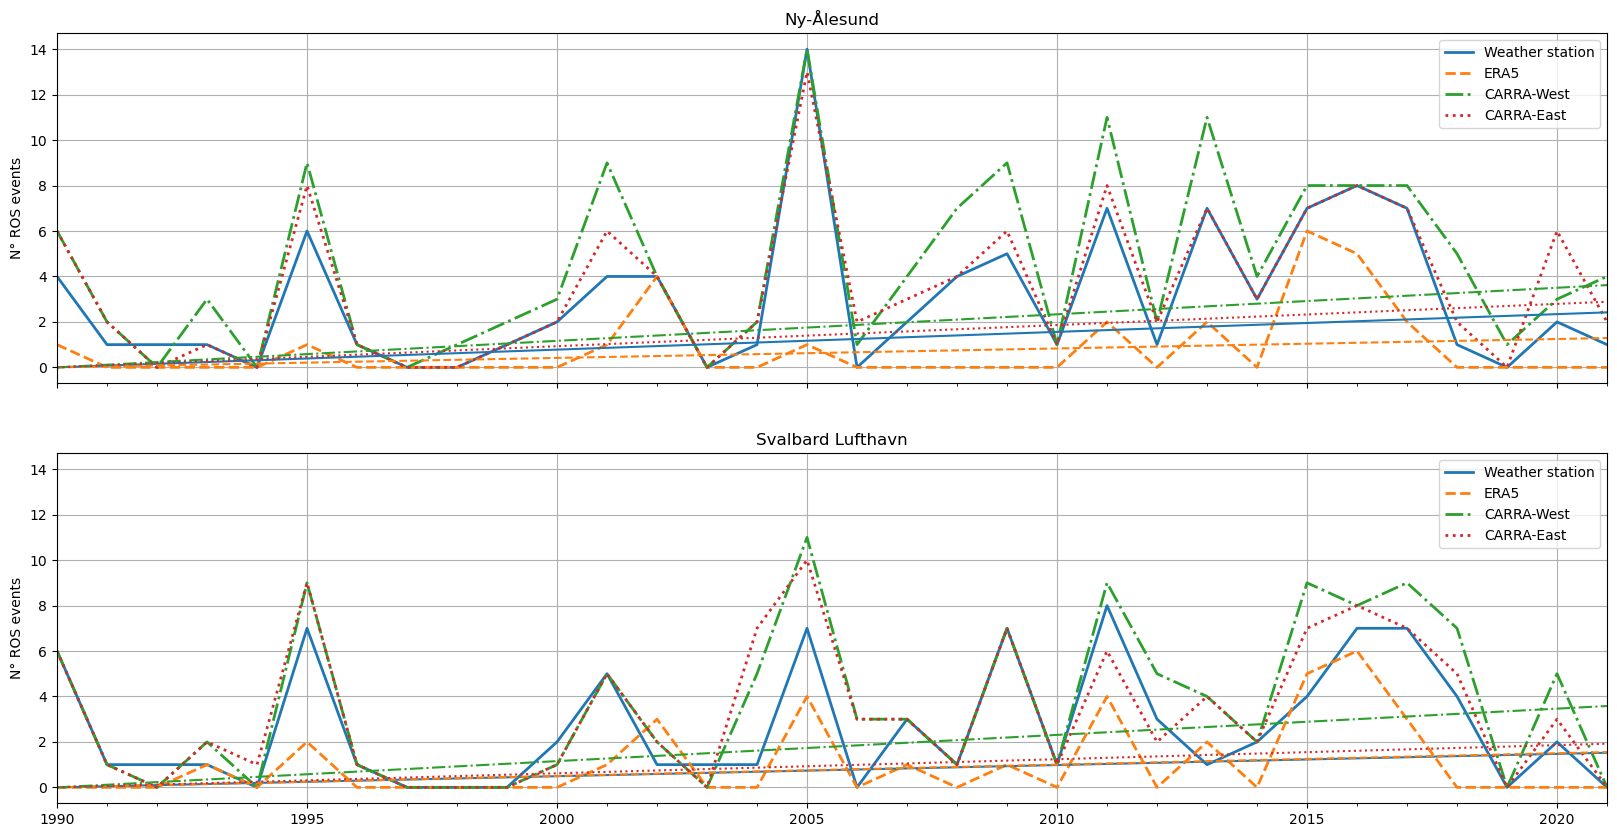

In [27]:
plot_ros_events(df_n_ros_ny_alesund_samegaps, df_n_ros_svalbard_lufthavn_samegaps)

*Fig. 6: Number of ROS events for each winter season between December 1990 and February 2022, and corresponding linear regression lines. The upper subplot shows the results for Ny-Ålesund, whereas the lower subplot for Svalbard Lufthavn. Note that the intercept of the linear regression lines is set to zero to allow for a better comparison.*

In [28]:
df_abs_diff_n_ros_svalbard_lufthavn = abs_diff_n_ros_single_station(df_n_ros_svalbard_lufthavn_samegaps, 'Svalbard Lufthavn')
df_abs_diff_n_ros_ny_alesund = abs_diff_n_ros_single_station(df_n_ros_ny_alesund_samegaps, 'Ny-Ålesund')
pd.concat([df_abs_diff_n_ros_ny_alesund, df_abs_diff_n_ros_svalbard_lufthavn], axis=1)

,Ny-Ålesund,Svalbard Lufthavn
ERA5,2.2,1.8
CARRA-West,1.5,1.2
CARRA-East,0.7,1.0


*Table 1: Average over the entire period of the absolute difference between the winter-time number of ROS events from observations and the reanalysis datasets. The first row shows the result for ERA5, the second for CARRA-West, and the third for CARRA-East. The column on the left shows the results for the weather station at Ny-Ålesund, while that on the right for the weather station at Svalbard Lufthavn.*

We conclude with a brief discussion on the linear trends of the number of ROS events at Ny-Ålesund and at Svalbard Lufthavn. The analysis of the linear trends serves a dual purpose. At first, it helps evaluate the quality of the reanalysis datasets. Secondly, it helps quantify the potential impact of climate change on the occurrence of ROS events over Svalbard. The results from the linear trend analysis is shown in the cells below and in Fig. 6. 

The linear trends suggest an increase in the number of ROS events at both Ny-Ålesund and Svalbard Lufthavn since 1990. The linear trend provided by CARRA-East aligns most closely with observations at Ny-Ålesund. At Svalbard Lufthavn, the results are more ambiguous, with both CARRA-East and ERA5 best resembling the observations. We should note, however, that the width of the confidence intervals questions the statistical significance of the results. Therefore, both the observations and the reanalysis datasets suggest that longer timeseries are needed to obtain statistically significant results and to determine whether climate change has affected the occurrence of ROS events over the Svalbard Archipelago. 

In [29]:
linear_trend_and_uncertainty_ros_at_single_station(df_n_ros_ny_alesund_samegaps, 'Ny-Ålesund')

slope +/- 95% confidence interval at Ny-Ålesund:

    0.08 +/- 0.13  (Weather station)
    0.04 +/- 0.06  (ERA5)
    0.12 +/- 0.15  (CARRA-West)
    0.09 +/- 0.12  (CARRA-East)


In [30]:
linear_trend_and_uncertainty_ros_at_single_station(df_n_ros_svalbard_lufthavn_samegaps, 'Svalbard Lufthavn')

slope +/- 95% confidence interval at Svalbard Lufthavn:

    0.05 +/- 0.10  (Weather station)
    0.05 +/- 0.06  (ERA5)
    0.12 +/- 0.13  (CARRA-West)
    0.06 +/- 0.12  (CARRA-East)


## ℹ️ If you want to know more

### Key resources

CDS dataset used:

* [Arctic regional reanalysis on single levels from 1991 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-carra-single-levels?tab=overview)

Code libraries used:

* [datetime](https://docs.python.org/3/library/datetime.html)
* [numpy](https://numpy.org/)
* [scipy](https://scipy.org/)
* [pandas](https://pandas.pydata.org/) 
* [xarray](https://docs.xarray.dev/en/stable/) 
* [matplotlib](https://matplotlib.org/) 
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) 
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Additional resources: 

* [State of the Climate in 2023: the Arctic](https://ametsoc.net/sotc2023/SoCin2023_Ch5_The%20Arctic.pdf)
* ["Climate in Svalbard 2100" report by the Norwegian Environmental Agency](https://www.miljodirektoratet.no/globalassets/publikasjoner/m1242/m1242.pdf)
* [AROSS: a Knowledge & Data Hub to explore the causes and impacts of Arctic Rain on Snow events](https://nsidc.org/rain-on-snow#:~:text=Rain%20on%20Snow%20(ROS)%20events,wildlife%2C%20infrastructure%2C%20and%20communities.)


### References 

* Batrak, Y., Cheng, B., Kallio-Myers, V. 2024 Sea ice cover in the Copernicus Arctic Regional Reanalysis. Cryosphere 18, 1157-1183. https://doi.org/10.5194/tc-18-1157-2024 

* Box, J. E., Nielsen, K. P., Yang, X., Niwano, M., Wehrlé, A., et al. 2023 Greenland ice sheet rainfall climatology, extremes and atmospheric river rapids. Meteorol. Appl. 30, 4, e2134, https://doi.org/10.1002/met.2134 

* Hansen, B. B., Isaksen, K., Benestad, R. E., Kohler, J., Pedersen, Å. Ø., et al. 2014 Warmer and wetter winters: characteristics and implications of an extreme weather event in the High Arctic. Environ. Res. Lett., 9, 114021. https://doi.org/10.1088/1748-9326/9/11/114021

* Hanssen-Bauer, I., Førland, E. J., Hisdal, H., Mayer, S., Sandø, A. B., et al. 2019 Climate in Svalbard 2100 – a knowledge base for climate adaptation. NCCS Report no. 1/2019 (www.klimaservicesenter.no).

* Hersbach, H., Bell, B., Berrisford, P., Hirahara, S., Horányi, A., et al. 2020 The ERA5 global reanalysis. Q.J.R. Meteorol. Soc. 146, 1990–2049. https://doi.org/10.1002/qj.3803

* Peeters, B., Pedersen, Å. Ø., Loe, L. E., Isaksen, K., Veiberg, V., et al. 2019 Spatiotemporal patterns of rain-on-snow and basal ice in high Arctic Svalbard: detection of a climate-cryosphere regime shift. Environ. Res. Lett., 14, 015002. doi:10.1088/1748-9326/aaefb3.

* Rantanen, M., Karpechko, A. Y., Lipponen, A., Nordling, K., Hyvärinen, O., et al. 2022 The Arctic has warmed nearly four times faster than the globe since 1979. Commun. Earth Environ. 3, 168. doi:10.1038/s43247-022-00498-3.

* Wickström, S., Jonassen, M. O., Cassano, J. J., Vihma, T. 2020 Present Temperature, Precipitation, and Rain‐on‐Snow Climate in Svalbard. J. Geophys. Res. Atmos. 5, e2019JD032155. https://doi.org/10.1029/2019JD032155
